In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from datasets import Dataset, DatasetDict
import transformers
import peft
import accelerate
import argparse
import joblib
from transformers import AutoTokenizer
from models import (
    train_eval_distilbert_lora_no_features_model,
    train_eval_distilbert_lora_with_features_model,
    train_and_evaluate_model_distilbert_f,
    train_and_evaluate_model_distilbert_feature,
    train_sgd, evaluate_model_sgd,
    train_naive_bayes, evaluate_model_nb
)
from data_preprocessing import (
    data_preprocessing_original_file_dis_lora,
    split_raw_data_to_csv_dis_lora,
    data_preprocessing_freeze_last_layer_feature,
    data_preprocessing_freeze_last_layer_nofeature,
    preprocess_data_sgd, extract_linguistic_features_sgd,
    preprocess_data_nb, extract_linguistic_features_nb
)
from sklearn.metrics import accuracy_score, f1_score


In [13]:
import os
from datasets import load_dataset

# Load the dataset
# Login using e.g. `huggingface-cli login` to access the dataset
ds = load_dataset("LaiBenBen/STAT-8307-Group-Project-Gp17-Dataset")

# Create the 'data' folder if it doesn't exist
os.makedirs("data", exist_ok=True)

# Save each split of the dataset (train, validation, test) to CSV
for split in ds.keys():
    file_path = os.path.join("data", f"data_merged_original_yuke.csv")
    ds[split].to_csv(file_path, index=False)
    print(f"Saved {split} split to {file_path}")

data_merged_original_yuke.csv:   0%|          | 0.00/223M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Creating CSV from Arrow format:   0%|          | 0/100 [00:00<?, ?ba/s]

Saved train split to data/data_merged_original_yuke.csv


In [ ]:
data = pd.read_csv("./data/data_merged_original_yuke.csv")
print("Data loaded successfully.")


train_dataset, val_dataset, test_dataset, y_train, y_val, y_test, datas_train, datas_val, datas_test = data_preprocessing_freeze_last_layer_nofeature(data)
print("Data preprocessing completed successfully.")

accuracy, f1, model = train_and_evaluate_model_distilbert_f(train_dataset, val_dataset, y_val)

predictions = model.predict(test_dataset)
pred_labels = predictions.predictions.argmax(axis=1)
accuracy = accuracy_score(y_test, pred_labels)
f1_s = f1_score(y_test, pred_labels, average='weighted')

print(f"准确率: {accuracy}")
print(f"F1分数: {f1_s}")


predictions = model.predict(val_dataset)
pred_labels = predictions.predictions.argmax(axis=1)

logits = predictions.predictions
probabilities = torch.softmax(torch.tensor(logits), dim=-1).numpy()
predicted_labels = np.argmax(logits, axis=1)
predicted_probabilities = probabilities[np.arange(len(predicted_labels)), predicted_labels] # Probability of the predicted class

val_df = pd.DataFrame()
val_df['text'] = datas_val
val_df['label'] = y_val
val_df['prediction'] = pred_labels
val_df['pred_probability'] = predicted_probabilities
val_df['is_correct'] = (val_df['label'] == val_df['prediction'])

val_df['result_type'] = 'NA'
val_df.loc[(val_df['is_correct'] == True) & (val_df['label'] == 0), 'result_type'] = 'TN'
val_df.loc[(val_df['is_correct'] == True) & (val_df['label'] == 1), 'result_type'] = 'TP'
val_df.loc[(val_df['is_correct'] == False) & (val_df['label'] == 0), 'result_type'] = 'FP'
val_df.loc[(val_df['is_correct'] == False) & (val_df['label'] == 1), 'result_type'] = 'FN'


Data loaded successfully.
Which distilbert with lora model do you want to run? Enter 1 for model without features, 2 for model with features: 1
Duplicate text entries found. Removing duplicates...
Data after removing duplicates:
<class 'pandas.core.frame.DataFrame'>
Index: 99999 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    99999 non-null  object
 1   label   99999 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ MB
None


/content/data_preprocessing.py:552: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].apply(clean_text)


Text data cleaned.
Data preprocessing completed successfully.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Parameter: distilbert.embeddings.word_embeddings.weight, Requires Grad: False
Parameter: distilbert.embeddings.position_embeddings.weight, Requires Grad: False
Parameter: distilbert.embeddings.LayerNorm.weight, Requires Grad: False
Parameter: distilbert.embeddings.LayerNorm.bias, Requires Grad: False
Parameter: distilbert.transformer.layer.0.attention.q_lin.weight, Requires Grad: False
Parameter: distilbert.transformer.layer.0.attention.q_lin.bias, Requires Grad: False
Parameter: distilbert.transformer.layer.0.attention.k_lin.weight, Requires Grad: False
Parameter: distilbert.transformer.layer.0.attention.k_lin.bias, Requires Grad: False
Parameter: distilbert.transformer.layer.0.attention.v_lin.weight, Requires Grad: False
Parameter: distilbert.transformer.layer.0.attention.v_lin.bias, Requires Grad: False
Parameter: distilbert.transformer.layer.0.attention.out_lin.weight, Requires Grad: False
Parameter: distilbert.transformer.layer.0.attention.out_lin.bias, Requires Grad: False
Parame

Epoch,Training Loss,Validation Loss
1,0.200800,0.221545
2,0.162700,0.205714
3,0.143900,0.221301


准确率: 0.9226875
F1分数: 0.9223631807952255


准确率: 0.9244
F1分数: 0.9241933116931453


In [44]:
predictions = model.predict(val_dataset)
pred_labels = predictions.predictions.argmax(axis=1)
logits = predictions.predictions
probabilities = torch.softmax(torch.tensor(logits), dim=-1).numpy()
predicted_labels = np.argmax(logits, axis=1)
predicted_probabilities = probabilities[np.arange(len(predicted_labels)), predicted_labels] # Probability of the predicted class

val_df = pd.DataFrame()
val_df['text'] = datas_val
val_df['label'] = y_val
val_df['prediction'] = pred_labels
val_df['pred_probability'] = predicted_probabilities
val_df['is_correct'] = (val_df['label'] == val_df['prediction'])

val_df['result_type'] = 'NA'
val_df.loc[(val_df['is_correct'] == True) & (val_df['label'] == 0), 'result_type'] = 'TN'
val_df.loc[(val_df['is_correct'] == True) & (val_df['label'] == 1), 'result_type'] = 'TP'
val_df.loc[(val_df['is_correct'] == False) & (val_df['label'] == 0), 'result_type'] = 'FP'
val_df.loc[(val_df['is_correct'] == False) & (val_df['label'] == 1), 'result_type'] = 'FN'


In [45]:
# Separate correct and incorrect predictions
correct_df = val_df[val_df['is_correct']].copy()
incorrect_df = val_df[~val_df['is_correct']].copy()
tp_df = val_df[val_df['result_type'] == 'TP'].copy()
tn_df = val_df[val_df['result_type'] == 'TN'].copy()
fp_df = val_df[val_df['result_type'] == 'FP'].copy()
fn_df = val_df[val_df['result_type'] == 'FN'].copy()



--- Analyzing Text Length ---

Descriptive Statistics for Text Length:
Correct Predictions:
 count    14763.000000
mean      2240.517916
std       2825.780574
min          5.000000
25%        875.000000
50%       1051.000000
75%       3315.000000
max      48723.000000
Name: text_length, dtype: float64

Incorrect Predictions:
 count     1237.000000
mean      2083.552142
std       1680.390354
min         40.000000
25%        746.000000
50%       1563.000000
75%       3505.000000
max      21296.000000
Name: text_length, dtype: float64


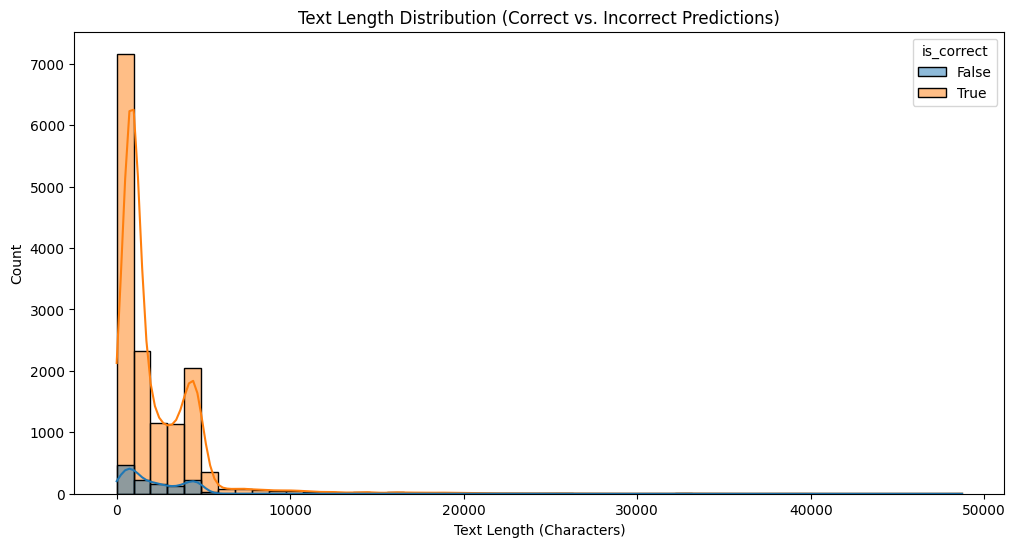

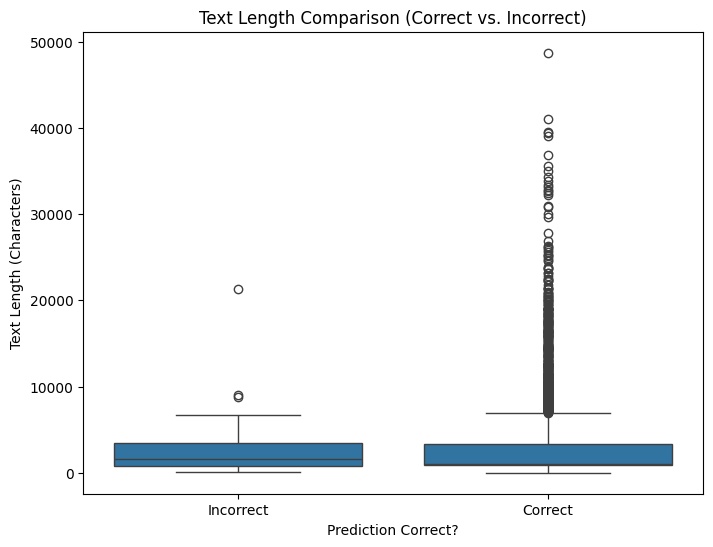

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
## 1 Text Length Analysis
print("\n--- Analyzing Text Length ---")
val_df['text_length'] = val_df['text'].apply(len)
correct_df['text_length'] = correct_df['text'].apply(len)
incorrect_df['text_length'] = incorrect_df['text'].apply(len)

print("\nDescriptive Statistics for Text Length:")
print("Correct Predictions:\n", correct_df['text_length'].describe())
print("\nIncorrect Predictions:\n", incorrect_df['text_length'].describe())

plt.figure(figsize=(12, 6))
sns.histplot(data=val_df, x='text_length', hue='is_correct', kde=True, bins=50)
plt.title('Text Length Distribution (Correct vs. Incorrect Predictions)')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Count')
#plt.savefig(os.path.join(OUTPUT_DIR, "length_histogram.png"))
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data=val_df, x='is_correct', y='text_length')
plt.title('Text Length Comparison (Correct vs. Incorrect)')
plt.xlabel('Prediction Correct?')
plt.ylabel('Text Length (Characters)')
plt.xticks([False, True], ['Incorrect', 'Correct'])
#plt.savefig(os.path.join(OUTPUT_DIR, "length_boxplot.png"))
plt.show()

In [47]:
from tqdm.notebook import tqdm
from textstat import difficult_words
import textstat
## 2 Text Complexity Analysis
print("\n--- Analyzing Text Complexity ---")

# Function to calculate all scores
def calculate_complexity(text):
  try:
    return pd.Series({
            'difficult_words': difficult_words(text)
        })
  except Exception:
    return pd.Series({
            'difficult_words': np.nan
        })


# Apply complexity calculations
tqdm.pandas(desc="Calculating Complexity")
complexity_scores = val_df['text'].progress_apply(calculate_complexity)
val_df = pd.concat([val_df, complexity_scores], axis=1)

val_df.head()


--- Analyzing Text Complexity ---


Calculating Complexity:   0%|          | 0/16000 [00:00<?, ?it/s]

,text,label,prediction,pred_probability,is_correct,result_type,text_length,difficult_words
0,buzzfeed via youtube meet the dallas bartender...,0,0,0.986054,True,TN,4194,102
1,she relaxed a bit and tried to speak but it se...,0,0,0.994907,True,TN,780,20
2,lincoln and his crew are aboard a space statio...,1,1,0.969260,True,TP,612,13
3,at the third presidential debate donald trump ...,0,1,0.941132,False,FP,1703,76
4,tottenham hotspur are in the market to sign re...,1,1,0.964369,True,TP,2058,77



Average Complexity Scores:
            difficult_words
is_correct                 
False             68.072757
True              65.186480


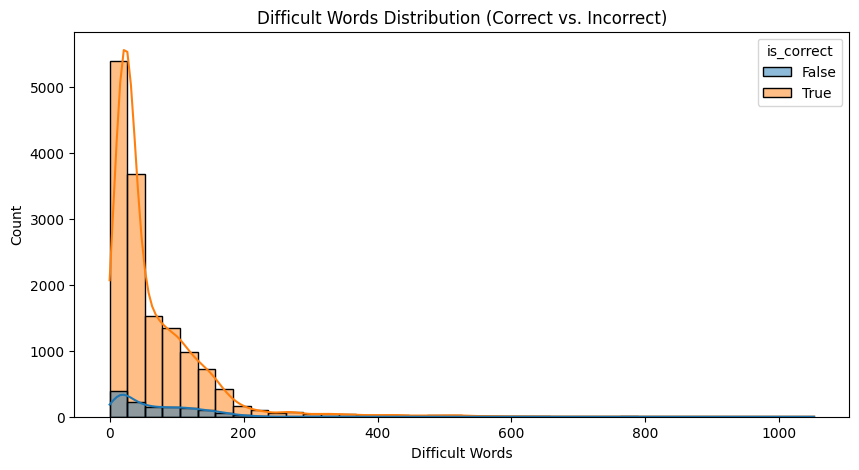

In [48]:
# Compare average scores
print("\nAverage Complexity Scores:")
print(val_df.groupby('is_correct')[['difficult_words']].mean())

# Plot distributions
complexity_metrics = ['difficult_words']
for metric in complexity_metrics:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=val_df, x=metric, hue='is_correct', kde=True, bins=40)
    plt.title(f'{metric.replace("_", " ").title()} Distribution (Correct vs. Incorrect)')
    plt.xlabel(metric.replace("_", " ").title())
    plt.ylabel('Count')
    #plt.savefig(os.path.join(OUTPUT_DIR, f"complexity_{metric}_hist.png"))
    plt.show()


--- Analyzing Text Complexity by Four Result Types (TN, FP, TP, FN) ---
Shape before duplicate removal: (16000, 8)
Shape after duplicate removal: (16000, 8)
Columns after duplicate removal: Index(['text', 'label', 'prediction', 'pred_probability', 'is_correct',
       'result_type', 'text_length', 'difficult_words'],
      dtype='object')

Descriptive Statistics for Complexity Metrics by Result Type:

--- Difficult Words ---
              count       mean         std  min   25%   50%    75%     max
result_type                                                               
TN           6822.0  71.649516  105.592374  0.0  22.0  29.0   66.0  1052.0
FP           1096.0  69.195255   56.220718  0.0  21.0  53.0  111.0   518.0
TP           7941.0  59.634177   45.957844  0.0  19.0  49.0   92.0   219.0
FN            141.0  59.347518   46.954687  1.0  18.0  49.0   93.0   203.0

Generating complexity plots by four result types (TN, FP, TP, FN)...


<ipython-input-49-52444f8c884a>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data_metric, x='result_type', y=metric, order=type_order, palette='viridis')


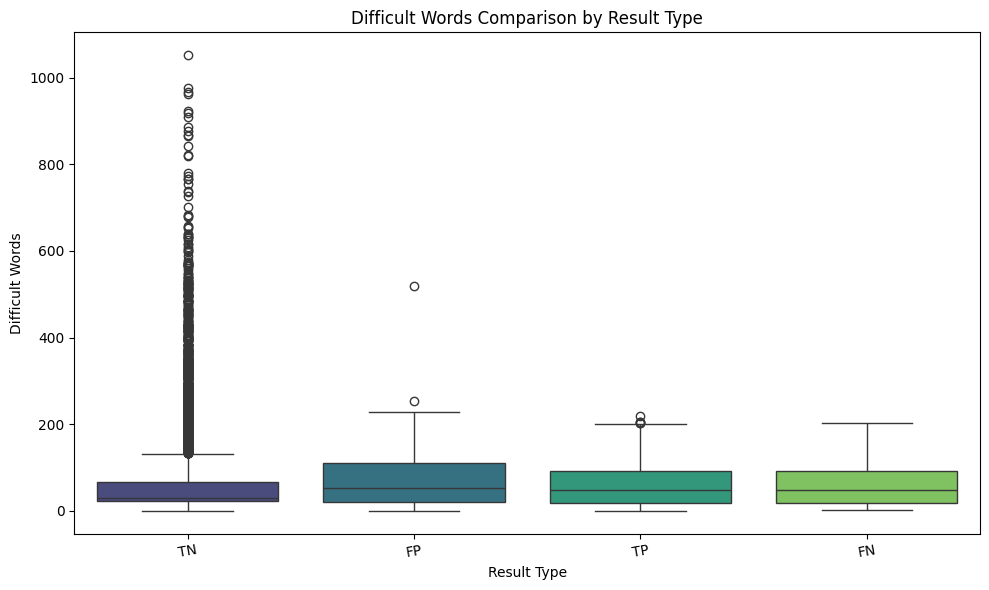

Could not generate legend for difficult_words histogram.


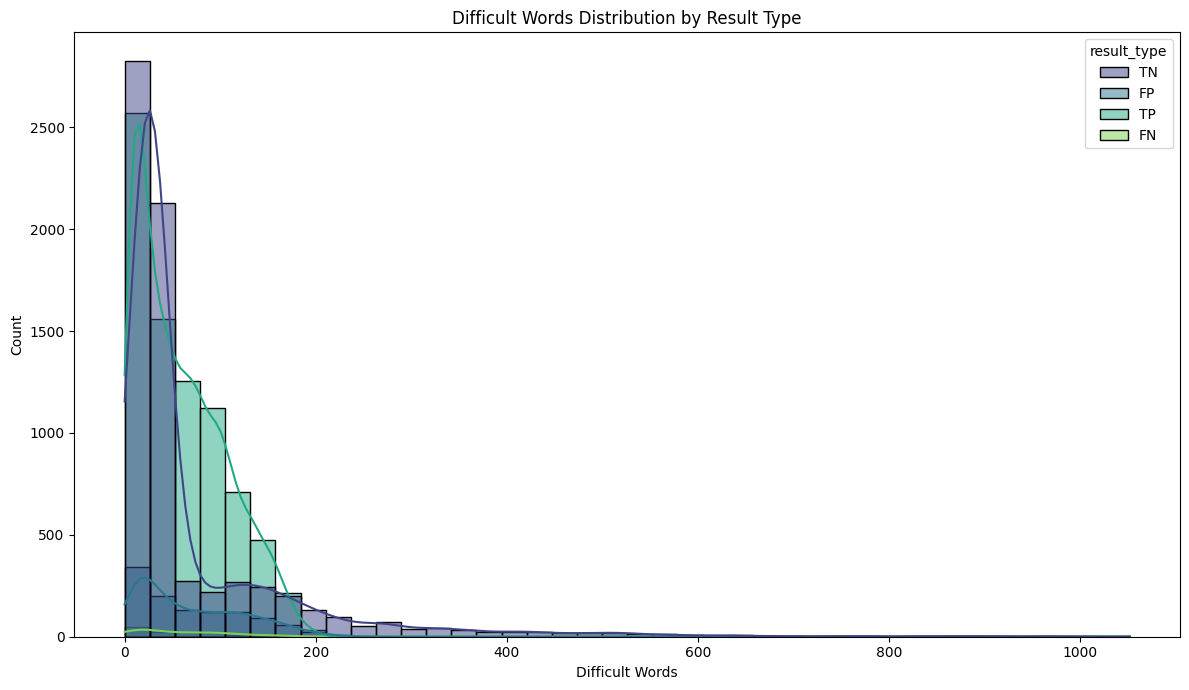

In [49]:
print("\n--- Analyzing Text Complexity by Four Result Types (TN, FP, TP, FN) ---")

type_order = ['TN', 'FP', 'TP', 'FN']
print("Shape before duplicate removal:", val_df.shape)
val_df = val_df.loc[:, ~val_df.columns.duplicated(keep='first')]
print("Shape after duplicate removal:", val_df.shape)
print("Columns after duplicate removal:", val_df.columns)

plot_data_four_types = val_df[val_df['result_type'].isin(type_order)].copy()

print("\nDescriptive Statistics for Complexity Metrics by Result Type:")
for metric in complexity_metrics:
    if metric in plot_data_four_types.columns:
        print(f"\n--- {metric.replace('_', ' ').title()} ---")
        stats = plot_data_four_types.groupby('result_type')[metric].describe()
        try:
            print(stats.reindex(type_order))
        except KeyError:
            print("Warning: Not all result types found in data for stats ordering.")
            print(stats)
    else:
        print(f"Metric '{metric}' not found for descriptive stats.")


print("\nGenerating complexity plots by four result types (TN, FP, TP, FN)...")
for metric in complexity_metrics:
    if metric in plot_data_four_types and pd.api.types.is_numeric_dtype(plot_data_four_types[metric]):

        plot_data_metric = plot_data_four_types.dropna(subset=[metric, 'result_type'])

        if not plot_data_metric.empty:
            # 1. Box Plot
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=plot_data_metric, x='result_type', y=metric, order=type_order, palette='viridis')
            plt.title(f'{metric.replace("_", " ").title()} Comparison by Result Type')
            plt.xlabel('Result Type')
            plt.ylabel(metric.replace("_", " ").title())
            plt.xticks(rotation=10)
            plt.tight_layout()
            #plt.savefig(os.path.join(OUTPUT_DIR, f"complexity_{metric}_boxplot_four_types.png"))
            plt.show()

            # 2. Histogram
            plt.figure(figsize=(12, 7))
            # Use histplot with hue
            ax = sns.histplot(data=plot_data_metric, x=metric, hue='result_type',
                              hue_order=type_order, kde=True, bins=40, palette='viridis',
                              common_norm=False)
            plt.title(f'{metric.replace("_", " ").title()} Distribution by Result Type')
            plt.xlabel(metric.replace("_", " ").title())
            plt.ylabel('Count')

            handles, labels = ax.get_legend_handles_labels()
            if handles and labels:
                 ax.legend(handles=handles, labels=labels, title='Result Type', bbox_to_anchor=(1.02, 1), loc='upper left')
                 plt.subplots_adjust(right=0.85)
            else:
                 print(f"Could not generate legend for {metric} histogram.")
                 plt.tight_layout()

            #plt.savefig(os.path.join(OUTPUT_DIR, f"complexity_{metric}_hist_four_types.png"))
            plt.show()
        else:
            print(f"No valid data to plot for {metric} across four types after dropping NaNs.")
    else:
        print(f"Skipping plots for {metric} as column is missing or not numeric in filtered data.")


--- Analyzing Top Keywords ---

Top 20 Keywords for Correct Predictions:
   Keyword  Frequency
0     said      14048
1   people      13441
2      new      12346
3     time      10493
4     like       9894
5     just       9607
6     make       7655
7      way       6454
8      use       6400
9     know       5838
10   world       5819
11   years       5590
12    good       5191
13    work       5119
14    dont       5072
15    want       4974
16   going       4893
17    need       4864
18    used       4748
19   think       4687


<ipython-input-51-420cfd37b626>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


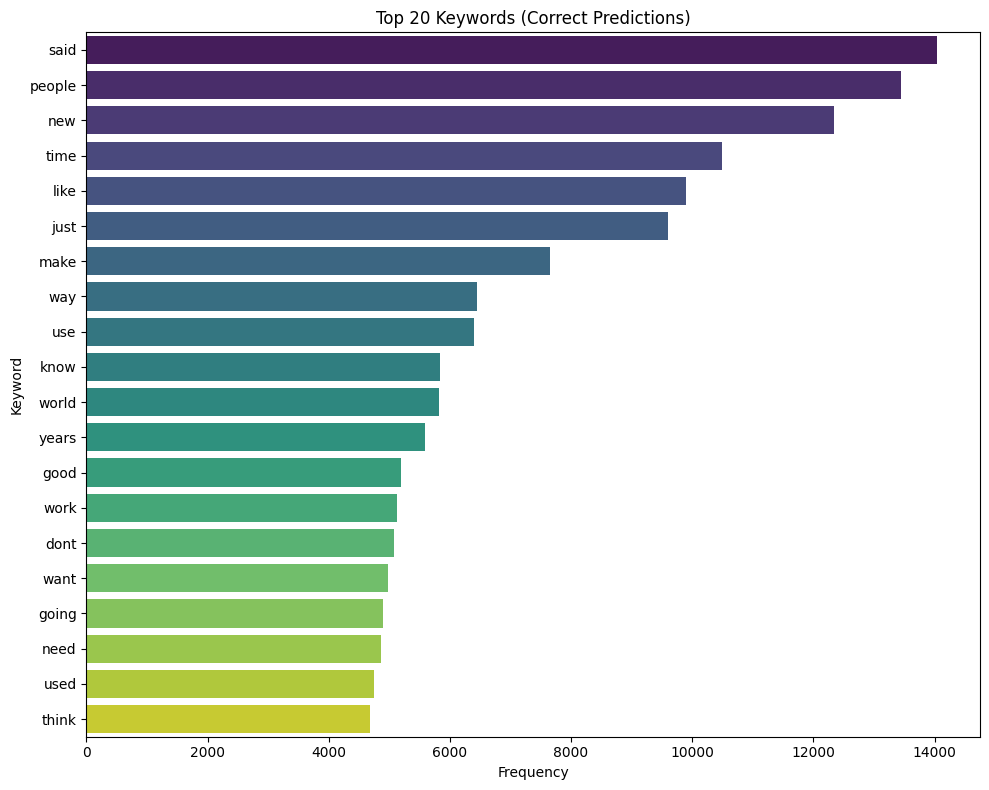


Top 20 Keywords for Incorrect Predictions:
   Keyword  Frequency
0     said       1409
1      new        857
2   people        828
3     just        729
4     time        729
5     like        686
6      use        477
7     year        474
8    years        467
9     make        461
10     way        417
11    dont        417
12   state        398
13    game        393
14    know        379
15   think        359
16   going        353
17   world        351
18    want        334
19    work        328


<ipython-input-51-420cfd37b626>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


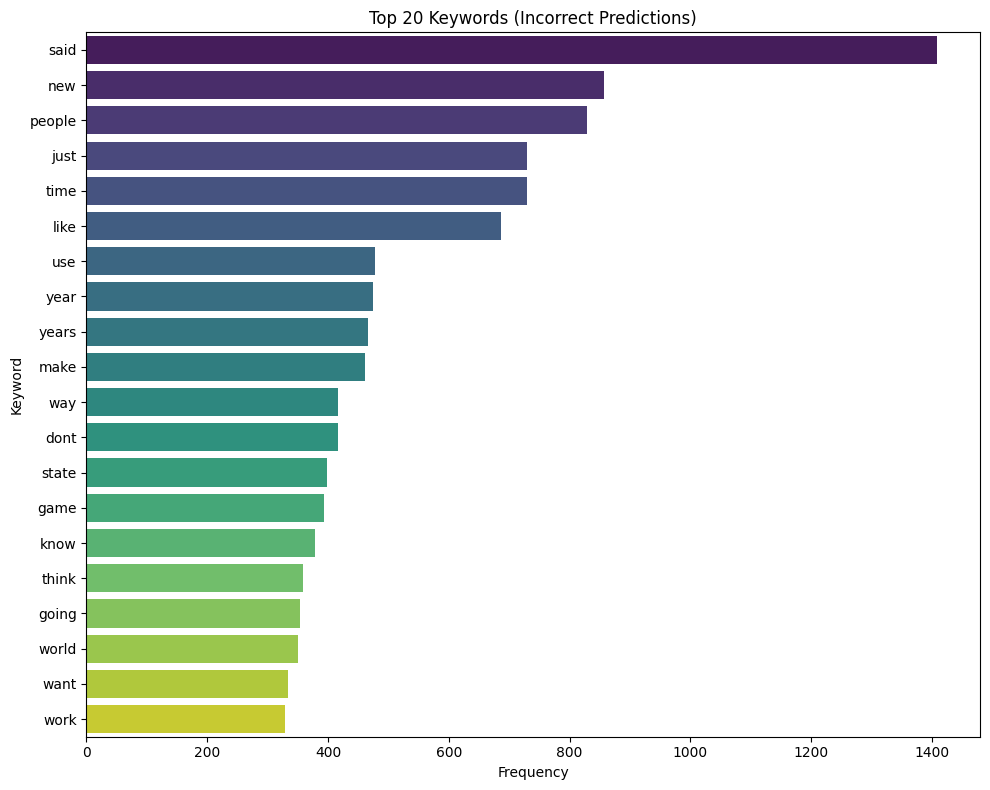

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
## 3 Keyword Analysis
print("\n--- Analyzing Top Keywords ---")

def plot_top_keywords(df, text_column, title_suffix, num_keywords=20, filename_suffix=""):
    if len(df) == 0:
        print(f"Skipping keyword analysis for '{title_suffix}': No samples.")
        return

    print(f"\nTop {num_keywords} Keywords for {title_suffix}:")
    try:
        vec = CountVectorizer(stop_words='english', max_features=num_keywords).fit(df[text_column])
        bag_of_words = vec.transform(df[text_column])
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

        top_df = pd.DataFrame(words_freq[:num_keywords], columns=['Keyword', 'Frequency'])
        print(top_df)

        plt.figure(figsize=(10, 8))
        sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')
        plt.title(f'Top {num_keywords} Keywords ({title_suffix})')
        plt.tight_layout()
        #plt.savefig(os.path.join(OUTPUT_DIR, f"keywords_{filename_suffix}.png"))
        plt.show()

    except ValueError as e:
        print(f"Could not generate keywords for {title_suffix}: {e}")

# Compare Correct vs Incorrect
plot_top_keywords(correct_df, 'text', 'Correct Predictions', filename_suffix="correct")
plot_top_keywords(incorrect_df, 'text', 'Incorrect Predictions', filename_suffix="incorrect")

# analyze FP and FN separately
# plot_top_keywords(fp_df, 'text', 'False Positives (Human -> AI)', filename_suffix="fp")
# plot_top_keywords(fn_df, 'text', 'False Negatives (AI -> Human)', filename_suffix="fn")


Top 20 Keywords for True Negatives (Human):
      Keyword  Frequency
0      people       5534
1        time       4904
2        like       4532
3        just       4129
4         new       3935
5        said       3278
6       world       2964
7     company       2916
8         way       2814
9         use       2682
10       life       2665
11       make       2470
12       work       2469
13       know       2447
14       used       2374
15  different       2363
16      years       2340
17   business       2114
18        man       2107
19        did       2095


<ipython-input-51-420cfd37b626>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


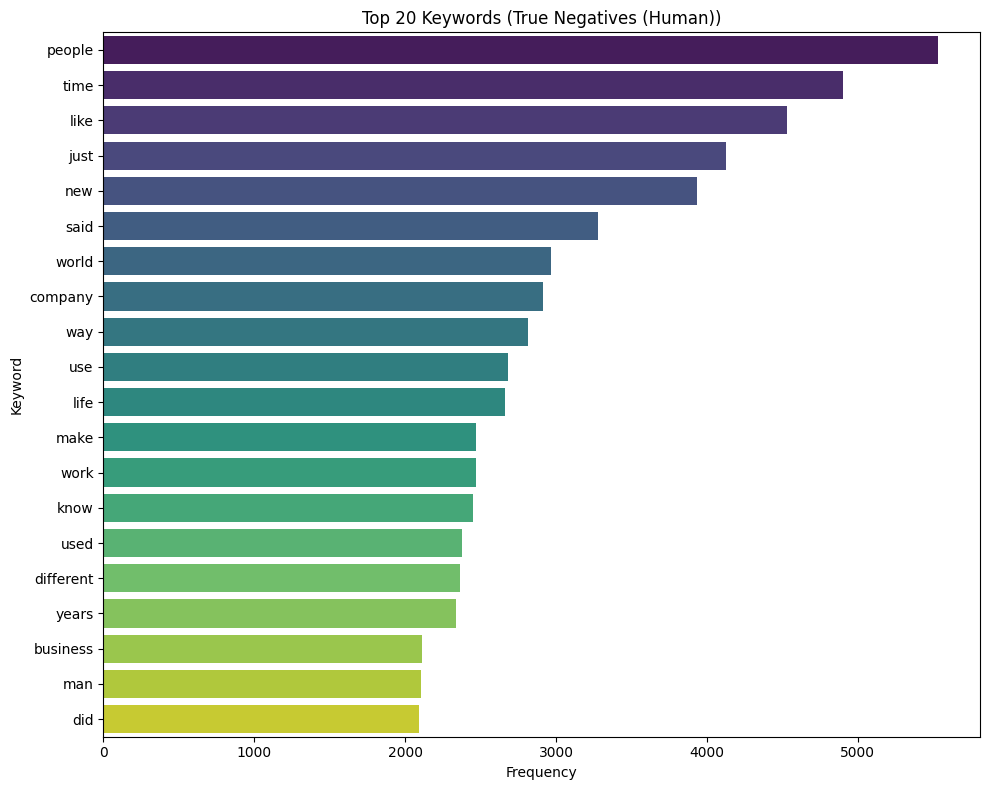


Top 20 Keywords for False Positives (Human -> AI):
   Keyword  Frequency
0     said       1302
1   people        755
2      new        737
3     time        657
4     just        647
5     like        606
6     year        418
7      use        415
8    years        402
9     make        401
10    dont        368
11     way        354
12   state        342
13    know        329
14   world        310
15   think        309
16  police        303
17    game        303
18   going        301
19    work        301


<ipython-input-51-420cfd37b626>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


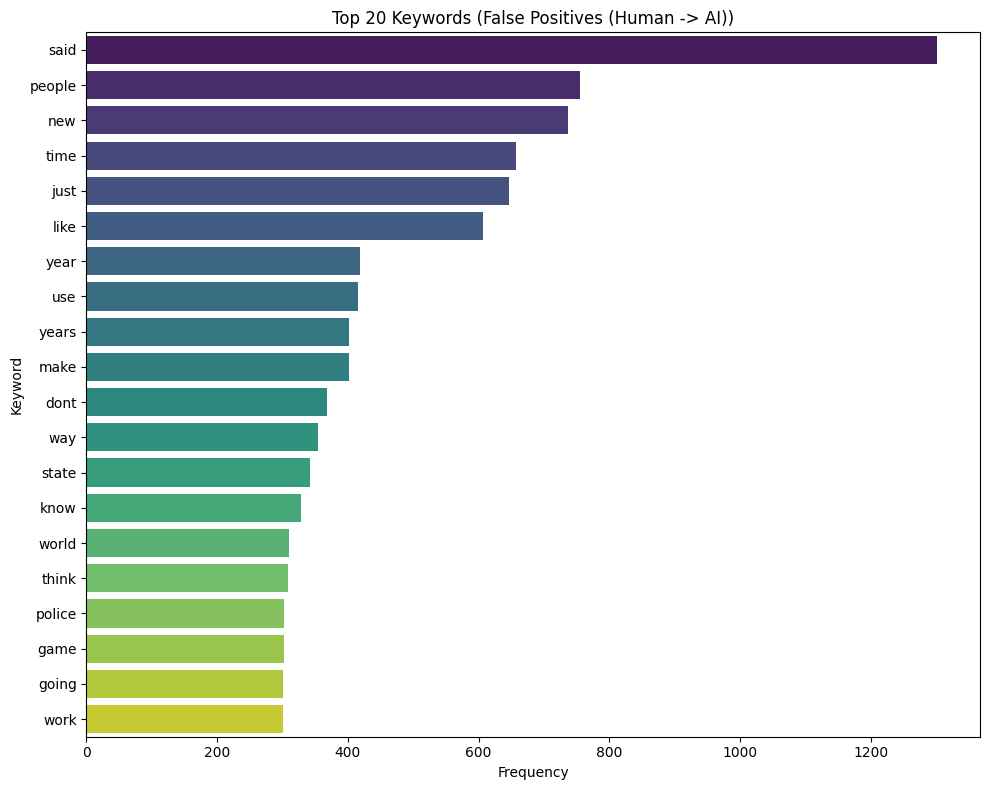


Top 20 Keywords for False Negatives (AI -> Human):
    Keyword  Frequency
0       new        120
1      said        107
2      game         90
3      just         82
4      like         80
5      best         74
6    people         73
7      time         72
8      days         70
9     years         65
10      way         63
11      use         62
12      day         60
13     make         60
14  support         59
15     year         56
16    state         56
17     used         55
18      did         55
19      war         55


<ipython-input-51-420cfd37b626>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


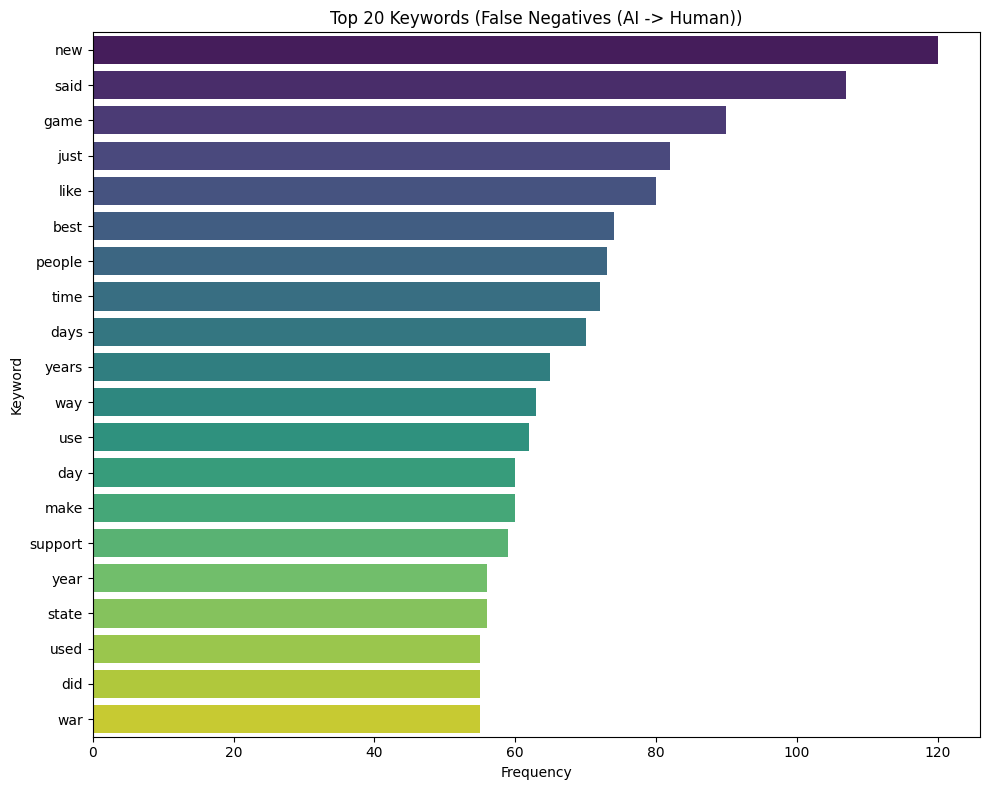


Top 20 Keywords for True Positives (AI):
       Keyword  Frequency
0         said      10770
1          new       8411
2       people       7907
3         time       5589
4         just       5478
5         like       5362
6         make       5185
7         want       3739
8          use       3718
9          way       3640
10        dont       3478
11       going       3463
12        know       3391
13       years       3250
14       think       3234
15        good       3225
16        year       3081
17        game       3000
18        need       2987
19  government       2948


<ipython-input-51-420cfd37b626>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


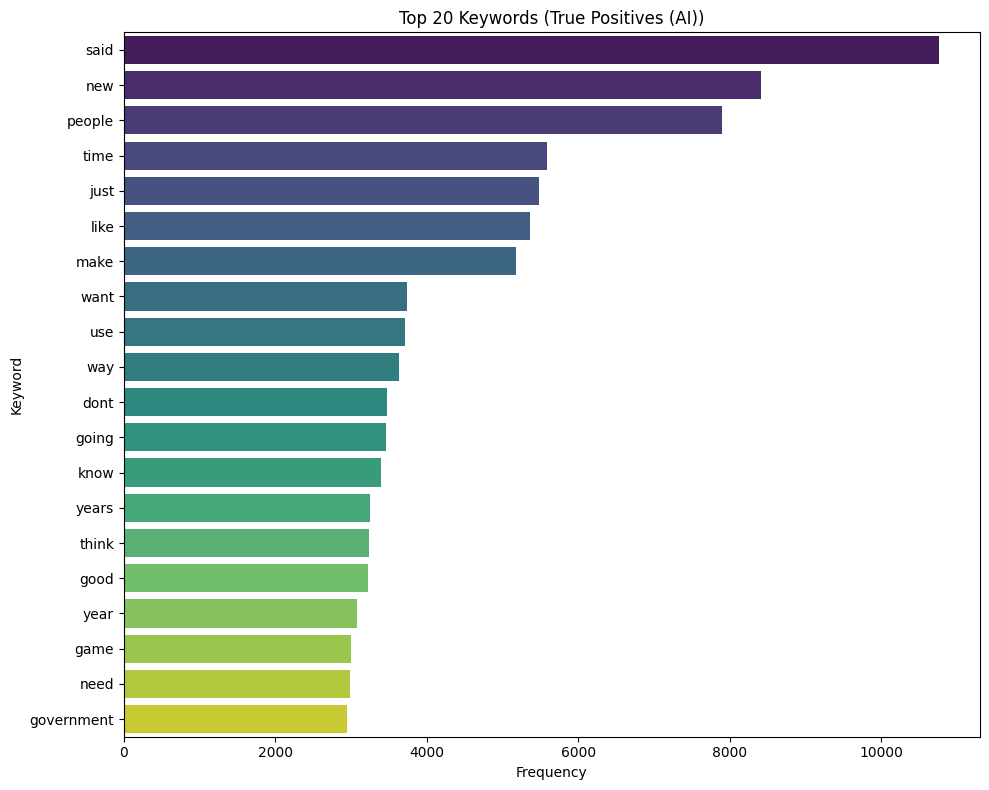

In [52]:
plot_top_keywords(tn_df, 'text', 'True Negatives (Human)', filename_suffix="tn")
plot_top_keywords(fp_df, 'text', 'False Positives (Human -> AI)', filename_suffix="fp")
plot_top_keywords(fn_df, 'text', 'False Negatives (AI -> Human)', filename_suffix="fn")
plot_top_keywords(tp_df, 'text', 'True Positives (AI)', filename_suffix="tp")


--- Analyzing N-grams ---

-- Top 2-grams --

Top 2-grams for Correct Predictions:
      2-gram  Frequency
0     of the      40672
1     in the      33501
2     to the      17309
3     on the      13516
4    and the      11051
5      to be      10617
6    for the      10081
7   that the       9608
8      it is       8427
9       in a       8277
10  with the       8068
11    at the       7646
12      is a       7528
13  from the       7087
14      of a       6722
15      as a       6214
16    by the       6071
17    it was       5971
18    is the       5132
19   will be       4939


<ipython-input-57-7826810ba9fb>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


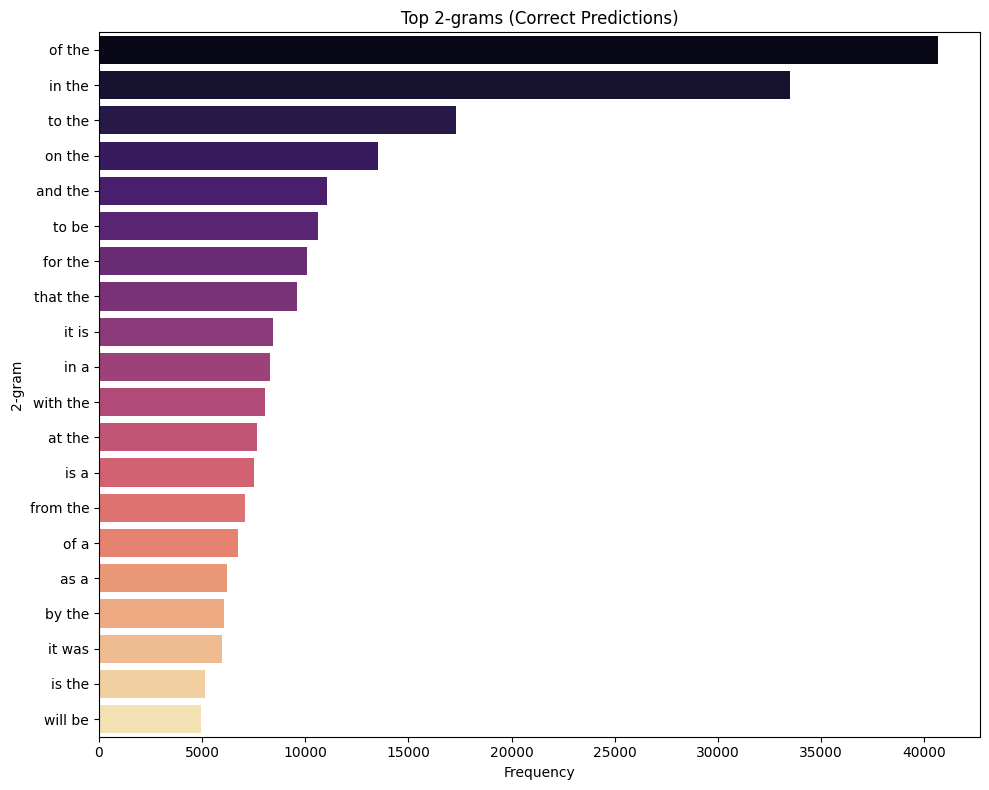


Top 2-grams for Incorrect Predictions:
       2-gram  Frequency
0      of the       2777
1      in the       2550
2      to the       1187
3      on the        951
4     for the        818
5       to be        663
6      at the        649
7     and the        647
8        in a        626
9    with the        608
10   that the        585
11       is a        557
12   from the        550
13       of a        501
14      it is        478
15     by the        476
16       as a        429
17  the first        396
18     with a        392
19    will be        354


<ipython-input-57-7826810ba9fb>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


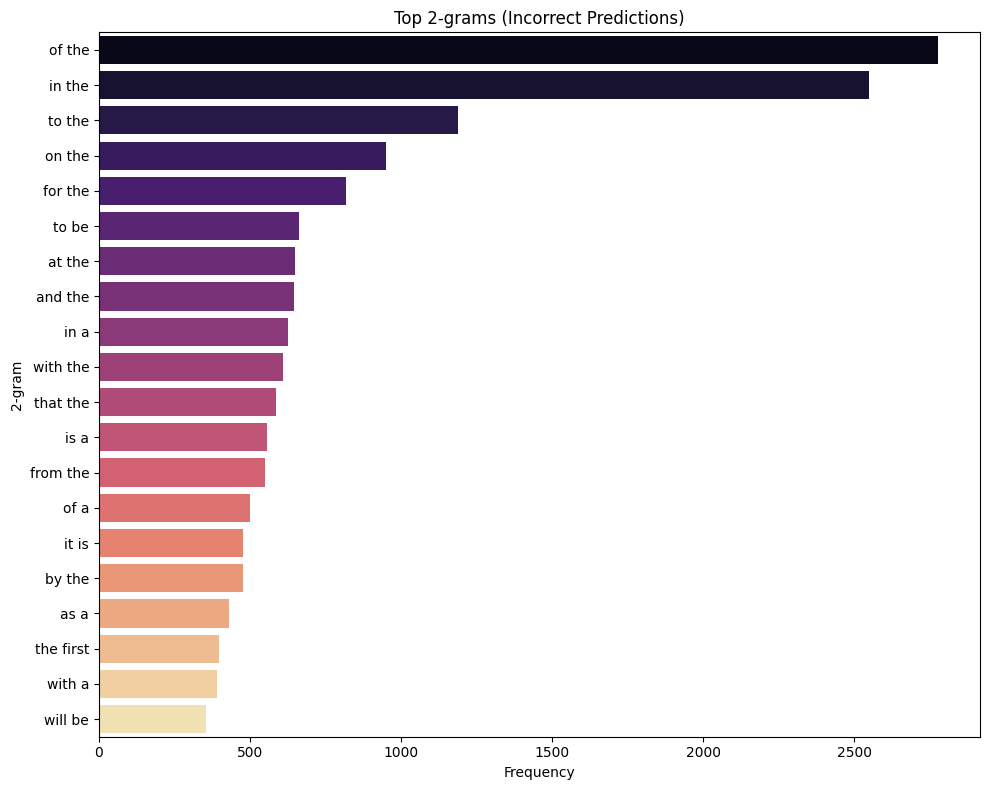


-- Top 3-grams --

Top 3-grams for Correct Predictions:
               3-gram  Frequency
0          one of the       2995
1            a lot of       2392
2   the united states       2286
3          as well as       1961
4          be able to       1528
5         in order to       1527
6       the fact that       1386
7         some of the       1257
8    according to the       1214
9             to be a       1079
10        a number of       1068
11      the number of        983
12        part of the        974
13         there is a        929
14         the use of        883
15         the end of        870
16          this is a        862
17        as a result        851
18       in the world        846
19         out of the        844


<ipython-input-57-7826810ba9fb>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


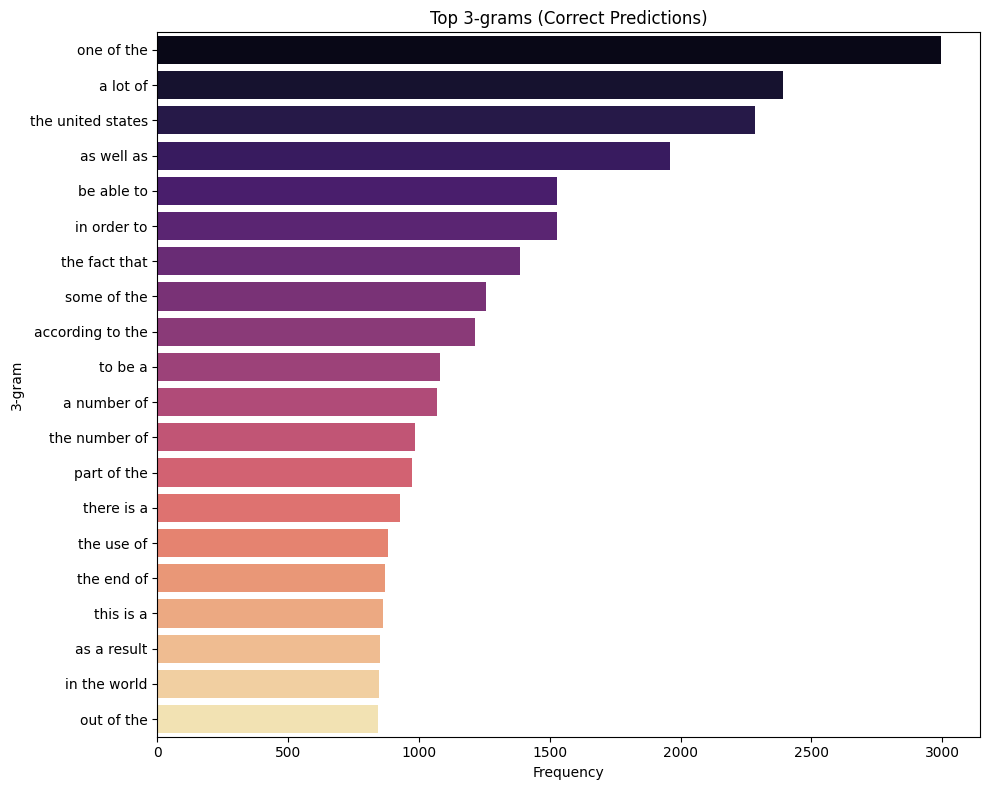


Top 3-grams for Incorrect Predictions:
               3-gram  Frequency
0          one of the        193
1            a lot of        125
2          as well as        120
3   the united states        114
4    according to the        113
5         some of the         91
6          be able to         81
7         part of the         80
8          the end of         76
9           this is a         67
10         there is a         66
11        in order to         66
12     the first time         65
13            to be a         64
14          in the us         60
15        a number of         59
16         out of the         59
17      the number of         58
18       in the world         55
19         at the end         55


<ipython-input-57-7826810ba9fb>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


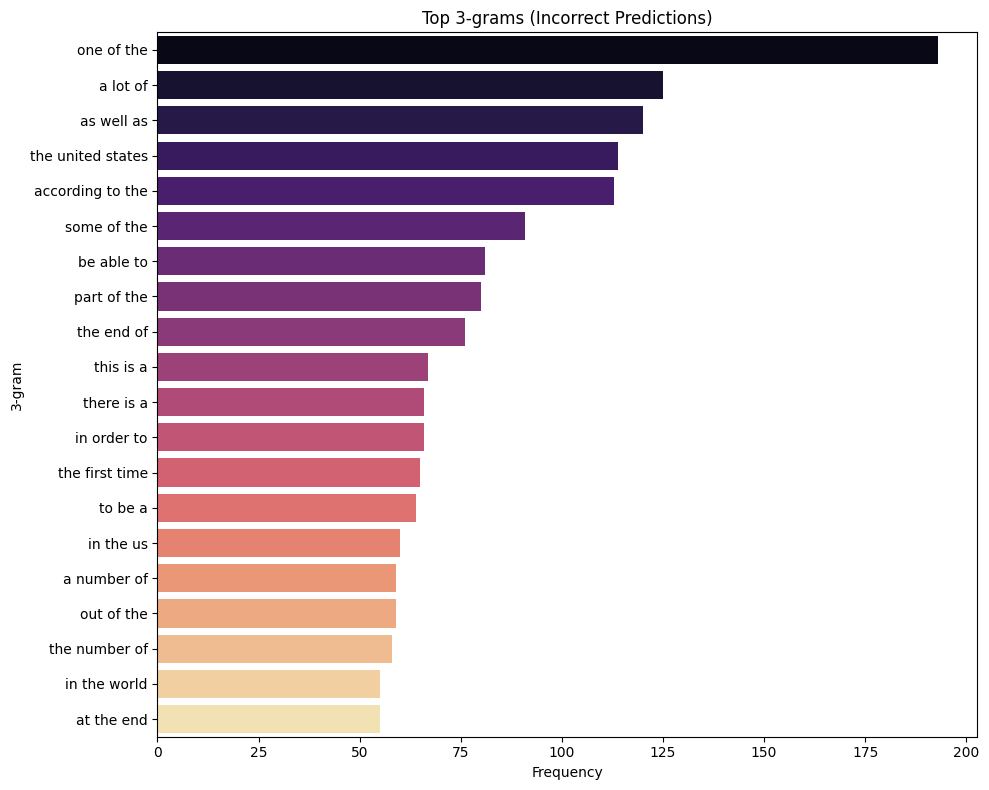

In [57]:
import re
import string
from collections import Counter
## 4 N-gram Analysis
print("\n--- Analyzing N-grams ---")

def get_top_ngrams(text_series, n=2, num_ngrams=20):
    if len(text_series) == 0:
        return pd.DataFrame(columns=[f'{n}-gram', 'Frequency'])

    # Simple whitespace and punctuation cleaning for n-grams
    def clean_for_ngrams(text):
        text = text.lower()
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text) # Remove punctuation
        text = re.sub(r'\s+', ' ', text).strip() # Normalize whitespace
        return text

    all_ngrams = []
    cleaned_texts = text_series.apply(clean_for_ngrams)
    for text in cleaned_texts:
        words = text.split()
        if len(words) >= n:
            grams = [" ".join(words[i:i+n]) for i in range(len(words) - n + 1)]
            all_ngrams.extend(grams)

    if not all_ngrams:
        return pd.DataFrame(columns=[f'{n}-gram', 'Frequency'])

    ngram_freq = Counter(all_ngrams)
    common_ngrams = ngram_freq.most_common(num_ngrams)
    return pd.DataFrame(common_ngrams, columns=[f'{n}-gram', 'Frequency'])

def plot_ngrams(df, title, filename):
    if df.empty:
        print(f"Skipping plot for '{title}': No n-grams found.")
        return
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')
    plt.title(title)
    plt.tight_layout()
    #plt.savefig(os.path.join(OUTPUT_DIR, filename))
    plt.show()


# Analyze Bigrams (n=2) and Trigrams (n=3)
for n_gram_size in [2, 3]:
    print(f"\n-- Top {n_gram_size}-grams --")

    # Correct
    top_ngrams_correct = get_top_ngrams(correct_df['text'], n=n_gram_size, num_ngrams=20)
    print(f"\nTop {n_gram_size}-grams for Correct Predictions:")
    print(top_ngrams_correct)
    plot_ngrams(top_ngrams_correct, f'Top {n_gram_size}-grams (Correct Predictions)', f"ngram{n_gram_size}_correct.png")

    # Incorrect
    top_ngrams_incorrect = get_top_ngrams(incorrect_df['text'], n=n_gram_size, num_ngrams=20)
    print(f"\nTop {n_gram_size}-grams for Incorrect Predictions:")
    print(top_ngrams_incorrect)
    plot_ngrams(top_ngrams_incorrect, f'Top {n_gram_size}-grams (Incorrect Predictions)', f"ngram{n_gram_size}_incorrect.png")

    # FP / FN
    # top_ngrams_fp = get_top_ngrams(fp_df['text'], n=n_gram_size, num_ngrams=15)
    # plot_ngrams(top_ngrams_fp, f'Top {n_gram_size}-grams (False Positives)', f"ngram{n_gram_size}_fp.png")
    # top_ngrams_fn = get_top_ngrams(fn_df['text'], n=n_gram_size, num_ngrams=15)
    # plot_ngrams(top_ngrams_fn, f'Top {n_gram_size}-grams (False Negatives)', f"ngram{n_gram_size}_fn.png")

<ipython-input-57-7826810ba9fb>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


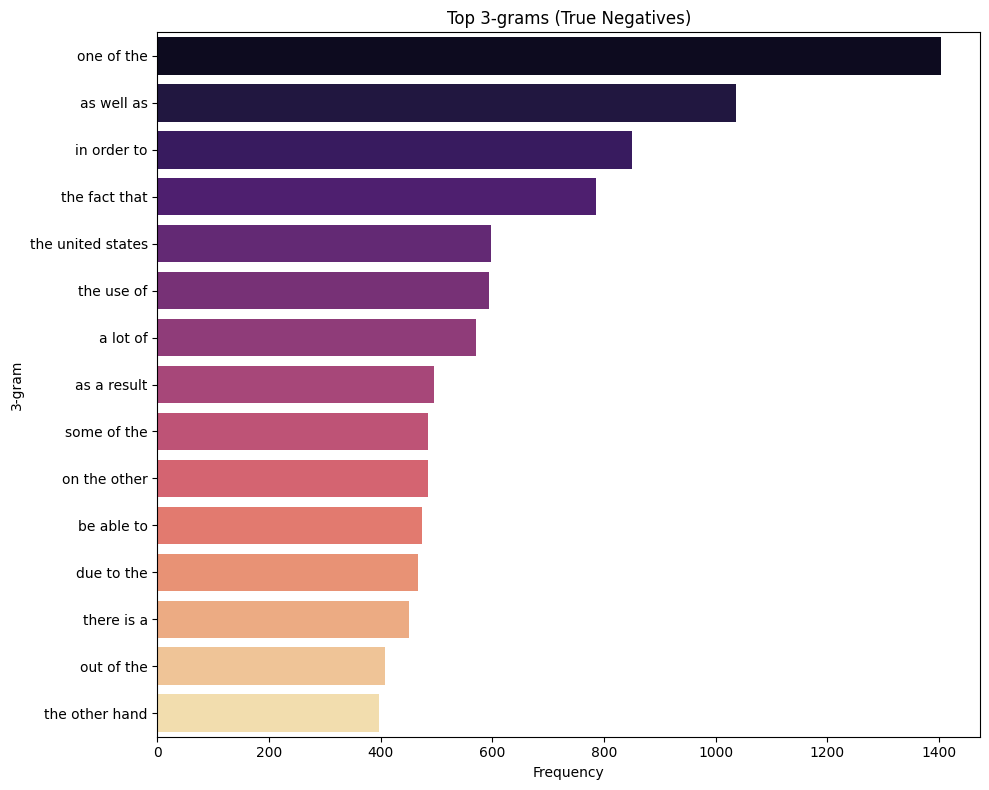

<ipython-input-57-7826810ba9fb>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


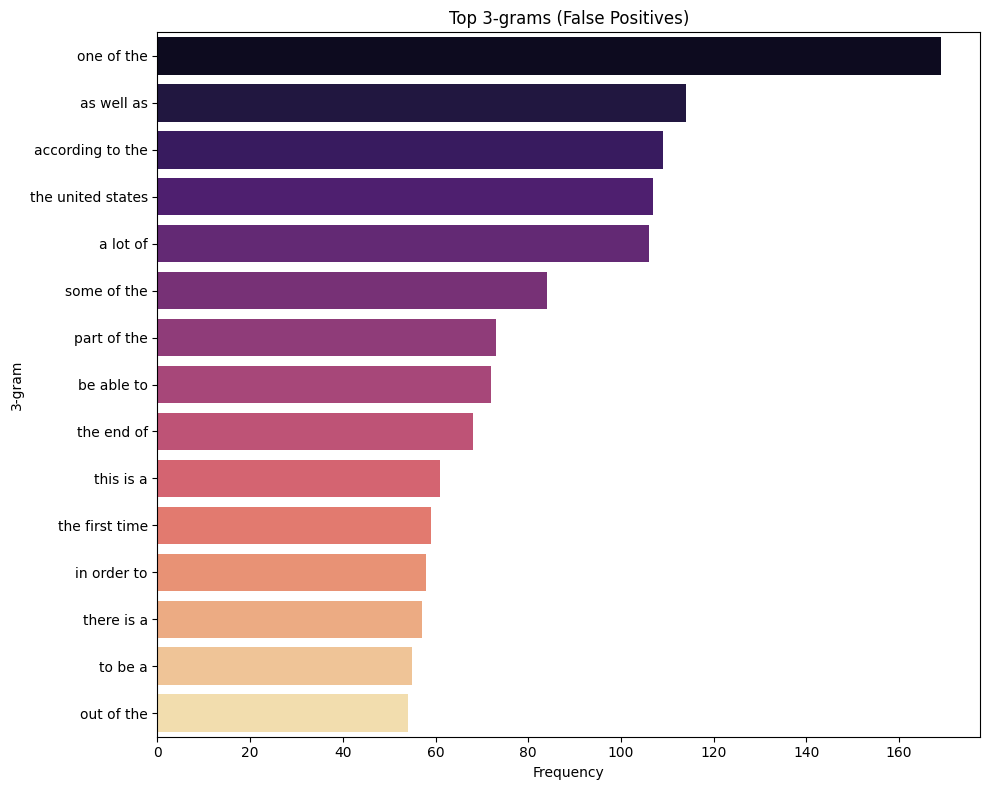

<ipython-input-57-7826810ba9fb>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


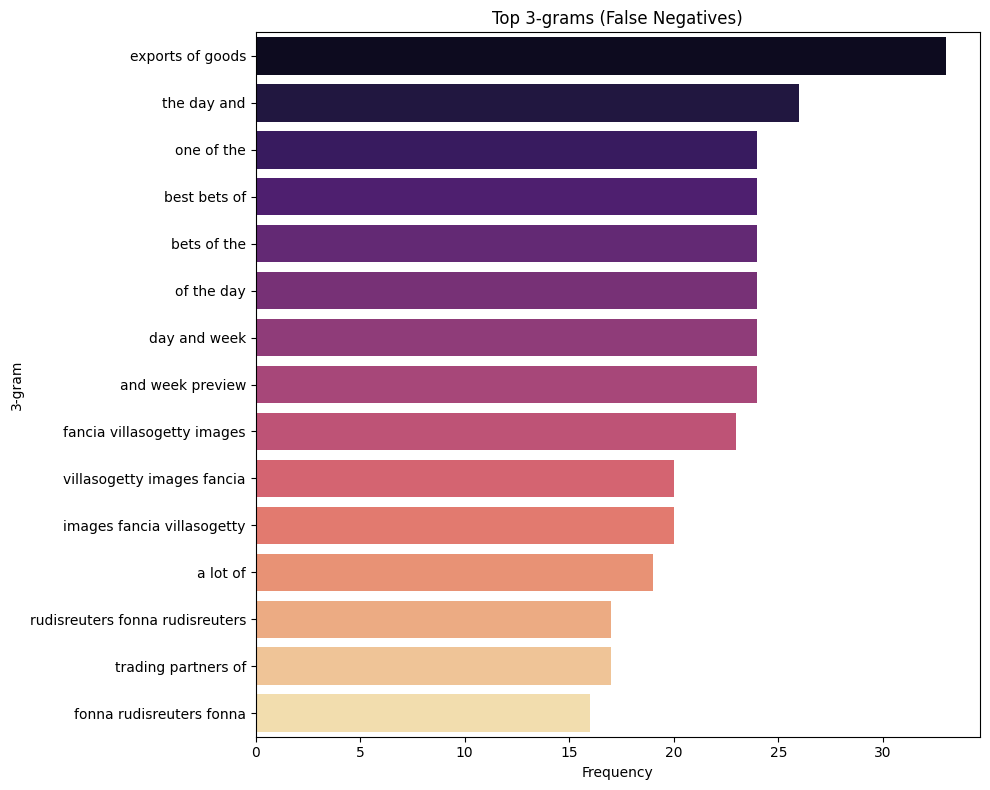

<ipython-input-57-7826810ba9fb>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


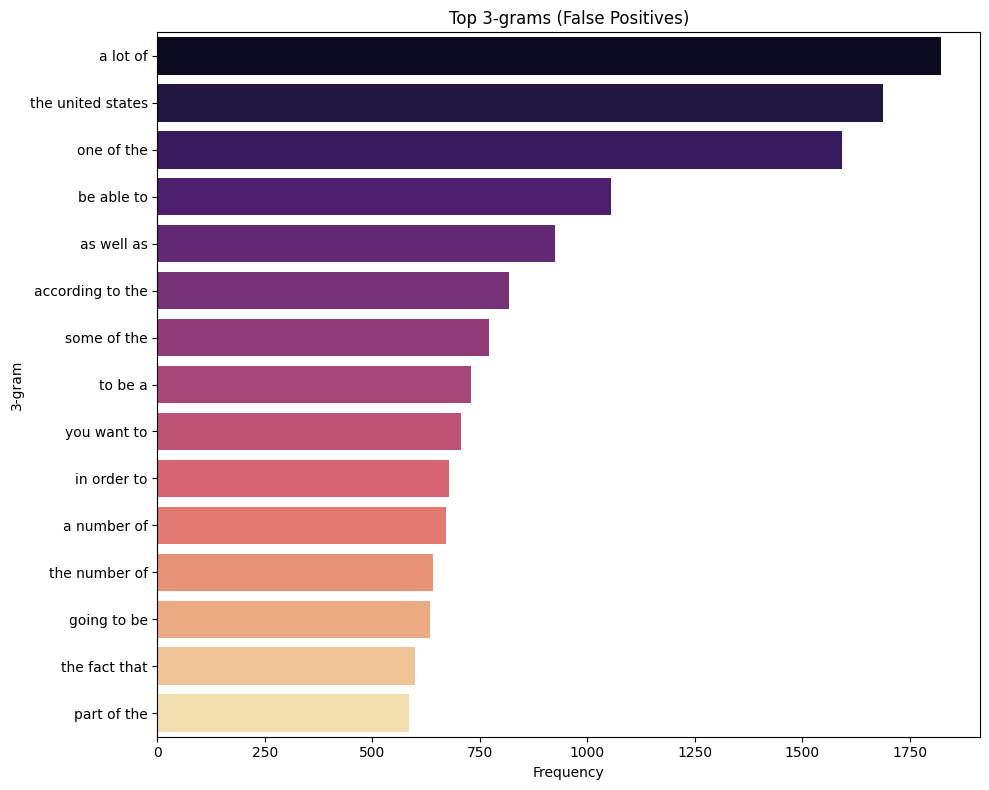

In [58]:

top_ngrams_tn = get_top_ngrams(tn_df['text'], n=n_gram_size, num_ngrams=15)
plot_ngrams(top_ngrams_tn, f'Top {n_gram_size}-grams (True Negatives)', f"ngram{n_gram_size}_tn.png")
top_ngrams_fp = get_top_ngrams(fp_df['text'], n=n_gram_size, num_ngrams=15)
plot_ngrams(top_ngrams_fp, f'Top {n_gram_size}-grams (False Positives)', f"ngram{n_gram_size}_fp.png")
top_ngrams_fn = get_top_ngrams(fn_df['text'], n=n_gram_size, num_ngrams=15)
plot_ngrams(top_ngrams_fn, f'Top {n_gram_size}-grams (False Negatives)', f"ngram{n_gram_size}_fn.png")
top_ngrams_tp = get_top_ngrams(tp_df['text'], n=n_gram_size, num_ngrams=15)
plot_ngrams(top_ngrams_tp, f'Top {n_gram_size}-grams (False Positives)', f"ngram{n_gram_size}_tp.png")


--- Analyzing Prediction Confidence ---


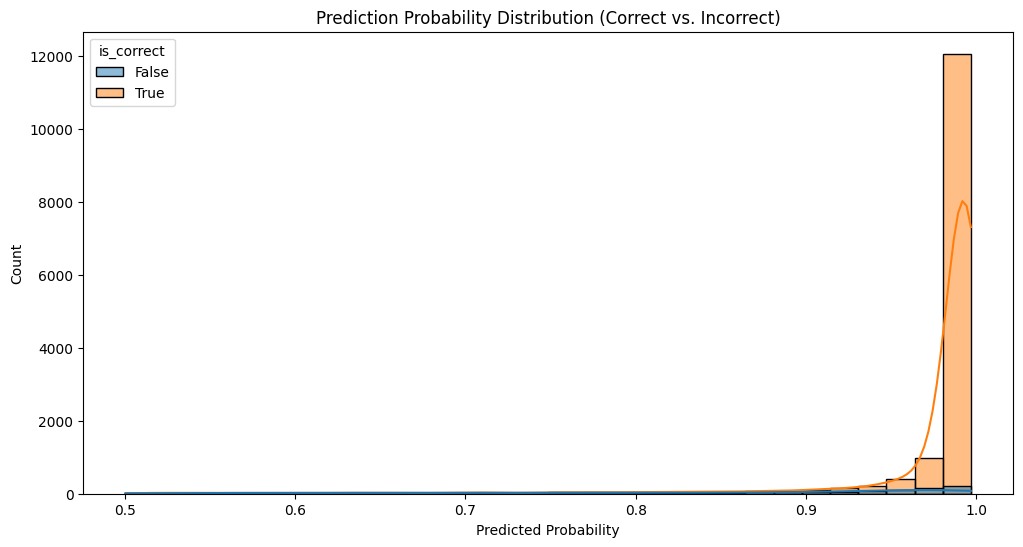


Average Prediction Probability:
is_correct
False    0.846597
True     0.973944
Name: pred_probability, dtype: float32


In [59]:
## 5 Confidence Analysis
print("\n--- Analyzing Prediction Confidence ---")
plt.figure(figsize=(12, 6))
sns.histplot(data=val_df, x='pred_probability', hue='is_correct', kde=True, bins=30)
plt.title('Prediction Probability Distribution (Correct vs. Incorrect)')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
#plt.savefig(os.path.join(OUTPUT_DIR, "confidence_histogram.png"))
plt.show()

print("\nAverage Prediction Probability:")
print(val_df.groupby('is_correct')['pred_probability'].mean())


--- Analyzing Prediction Confidence by result type ---


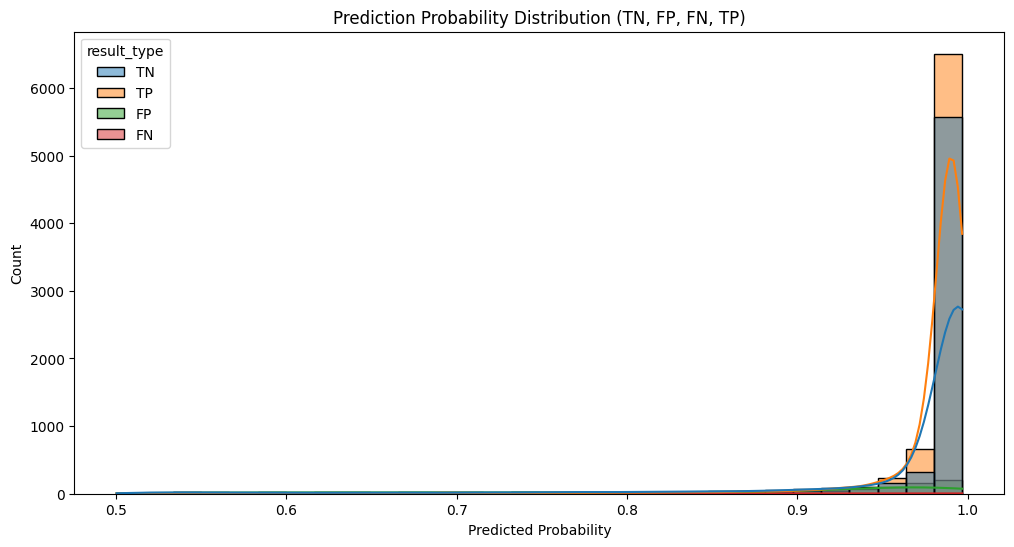


Average Prediction Probability:
result_type
FN    0.783322
FP    0.854738
TN    0.970010
TP    0.977324
Name: pred_probability, dtype: float32


In [60]:
print("\n--- Analyzing Prediction Confidence by result type ---")
plt.figure(figsize=(12, 6))
sns.histplot(data=val_df, x='pred_probability', hue='result_type', kde=True, bins=30)
plt.title('Prediction Probability Distribution (TN, FP, FN, TP)')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
#plt.savefig(os.path.join(OUTPUT_DIR, "confidence_histogram_by_type.png"))
plt.show()

print("\nAverage Prediction Probability:")
print(val_df.groupby('result_type')['pred_probability'].mean())

In [61]:
# --- 5.1 Analysis of High-Confidence Errors ---
print("\n--- Analyzing High-Confidence Errors ---")

# Define the confidence threshold
confidence_threshold = 0.90

text_col = 'text'
true_label_col = 'label'
pred_label_col = 'prediction'
prob_col = 'pred_probability'
correct_col = 'is_correct'

# Filter for incorrect predictions with high confidence
high_confidence_errors_df = val_df[
    (val_df[correct_col] == False) &
    (val_df[prob_col] > confidence_threshold)
].copy()

# Sort by probability to see the most confident errors first
high_confidence_errors_df = high_confidence_errors_df.sort_values(by=prob_col, ascending=False)

print(f"Found {len(high_confidence_errors_df)} examples where the prediction was incorrect")
print(f"but the model's confidence in the wrong prediction was > {confidence_threshold:.2f}")

# --- Displaying Examples ---

# Display the top N most confident errors
num_examples_to_show = 10

print(f"\n--- Top {num_examples_to_show} Most Confident Errors ---")

if len(high_confidence_errors_df) > 0:
    display_cols = [text_col, true_label_col, pred_label_col, prob_col]

    display_cols = [col for col in display_cols if col in high_confidence_errors_df.columns]

    for index, row in high_confidence_errors_df.head(num_examples_to_show).iterrows():
        print(f"\n--- Example Index: {index} ---")
        print(f"  True Label:       {row[true_label_col]}")
        print(f"  Predicted Label:  {row[pred_label_col]}")
        print(f"  Confidence (Wrong): {row[prob_col]:.4f}")
        # Print the first 500 characters of the text for brevity
        print(f"  Text Snippet:     {row[text_col][:500]}...")
        print("-" * 30)
else:
    print("No high-confidence errors found matching the criteria.")

# --- Saving Examples ---

if len(high_confidence_errors_df) > 0 and 'OUTPUT_DIR' in locals():
    try:
        output_filename = os.path.join(OUTPUT_DIR, f"high_confidence_errors_gt_{confidence_threshold:.2f}.csv")
        # Save to a CSV
        high_confidence_errors_df.to_csv(output_filename, index=False)
        print(f"\nSaved all {len(high_confidence_errors_df)} high-confidence error examples to: {output_filename}")
    except Exception as e:
        print(f"\nCould not save high-confidence errors to CSV: {e}")


--- Analyzing High-Confidence Errors ---
Found 656 examples where the prediction was incorrect
but the model's confidence in the wrong prediction was > 0.90

--- Top 10 Most Confident Errors ---

--- Example Index: 11189 ---
  True Label:       1
  Predicted Label:  0
  Confidence (Wrong): 0.9935
  Text Snippet:     a lot just like your hand just like your tongue aadorno she gasped you mean the old madman yeah exactly im notim sure youve heard that word before yes of course he shook his head you just dont know you know we dont really know what those words mean what youre talking about is a lot she said the universe my entire existence how many universes does it contain he shook his head all we can be sure of is that if someone is going to take control here one dayit wont be the last youre trying to tell me ...
------------------------------

--- Example Index: 12070 ---
  True Label:       0
  Predicted Label:  1
  Confidence (Wrong): 0.9930
  Text Snippet:     nonlawyers often ask me

In [62]:
train_dataset, val_dataset, test_dataset, y_train, y_val, y_test, datas_train, datas_val, datas_test = data_preprocessing_freeze_last_layer_feature(data)
print("Data preprocessing completed successfully.")

accuracy, f1, model = train_and_evaluate_model_distilbert_feature(train_dataset, val_dataset, y_val)

predictions = model.predict(test_dataset)
pred_labels = predictions.predictions.argmax(axis=1)
accuracy = accuracy_score(y_test, pred_labels)
f1_s = f1_score(y_test, pred_labels, average='weighted')
print(f"准确率: {accuracy}")
print(f"F1分数: {f1_s}")


predictions = model.predict(val_dataset)
pred_labels = predictions.predictions.argmax(axis=1)

logits = predictions.predictions
probabilities = torch.softmax(torch.tensor(logits), dim=-1).numpy()
predicted_labels = np.argmax(logits, axis=1)
predicted_probabilities = probabilities[np.arange(len(predicted_labels)), predicted_labels] # Probability of the predicted class

val_df = pd.DataFrame()
val_df['text'] = datas_val
val_df['label'] = y_val
val_df['prediction'] = pred_labels
val_df['pred_probability'] = predicted_probabilities
val_df['is_correct'] = (val_df['label'] == val_df['prediction'])

val_df['result_type'] = 'NA'
val_df.loc[(val_df['is_correct'] == True) & (val_df['label'] == 0), 'result_type'] = 'TN'
val_df.loc[(val_df['is_correct'] == True) & (val_df['label'] == 1), 'result_type'] = 'TP'
val_df.loc[(val_df['is_correct'] == False) & (val_df['label'] == 0), 'result_type'] = 'FP'
val_df.loc[(val_df['is_correct'] == False) & (val_df['label'] == 1), 'result_type'] = 'FN'


Duplicate text entries found. Removing duplicates...
Data after removing duplicates:
<class 'pandas.core.frame.DataFrame'>
Index: 99999 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    99999 non-null  object
 1   label   99999 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ MB
None


/content/data_preprocessing.py:623: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].apply(clean_text)


Text data cleaned.
Linguistic features extracted.
   flesch_reading_ease  flesch_kincaid_grade  smog_index  \
0             -7944.33                3081.2         0.0   
1              -119.01                  78.6         0.0   
2              -166.72                  96.9         0.0   
3              -578.13                 259.1         0.0   
4              -378.18                 176.1         0.0   

   dale_chall_readability_score  difficult_words  linsear_write_formula  \
0                        397.13              938                   75.0   
1                         16.50               34                   69.0   
2                         20.04               50                   66.0   
3                         38.73               65                   56.0   
4                         28.60               62                   58.0   

   gunning_fog  text_standard  
0      3158.21            0.0  
1        81.26           79.0  
2       100.99           97.0  
3       26

Some weights of DistilBertWithFeatures were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Custom model loaded.
Parameter: distilbert.embeddings.word_embeddings.weight, Requires Grad: False
Parameter: distilbert.embeddings.position_embeddings.weight, Requires Grad: False
Parameter: distilbert.embeddings.LayerNorm.weight, Requires Grad: False
Parameter: distilbert.embeddings.LayerNorm.bias, Requires Grad: False
Parameter: distilbert.transformer.layer.0.attention.q_lin.weight, Requires Grad: False
Parameter: distilbert.transformer.layer.0.attention.q_lin.bias, Requires Grad: False
Parameter: distilbert.transformer.layer.0.attention.k_lin.weight, Requires Grad: False
Parameter: distilbert.transformer.layer.0.attention.k_lin.bias, Requires Grad: False
Parameter: distilbert.transformer.layer.0.attention.v_lin.weight, Requires Grad: False
Parameter: distilbert.transformer.layer.0.attention.v_lin.bias, Requires Grad: False
Parameter: distilbert.transformer.layer.0.attention.out_lin.weight, Requires Grad: False
Parameter: distilbert.transformer.layer.0.attention.out_lin.bias, Requir

Epoch,Training Loss,Validation Loss
1,0.199400,0.211708
2,0.157600,0.211656
3,0.136800,0.230105


准确率: 0.9248125
F1分数: 0.9245188405493088


准确率: 0.92615
F1分数: 0.9259606918292779


In [63]:
predictions = model.predict(val_dataset)
pred_labels = predictions.predictions.argmax(axis=1)
logits = predictions.predictions
probabilities = torch.softmax(torch.tensor(logits), dim=-1).numpy()
predicted_labels = np.argmax(logits, axis=1)
predicted_probabilities = probabilities[np.arange(len(predicted_labels)), predicted_labels] # Probability of the predicted class

val_df = pd.DataFrame()
val_df['text'] = datas_val
val_df['label'] = y_val
val_df['prediction'] = pred_labels
val_df['pred_probability'] = predicted_probabilities
val_df['is_correct'] = (val_df['label'] == val_df['prediction'])

val_df['result_type'] = 'NA'
val_df.loc[(val_df['is_correct'] == True) & (val_df['label'] == 0), 'result_type'] = 'TN'
val_df.loc[(val_df['is_correct'] == True) & (val_df['label'] == 1), 'result_type'] = 'TP'
val_df.loc[(val_df['is_correct'] == False) & (val_df['label'] == 0), 'result_type'] = 'FP'
val_df.loc[(val_df['is_correct'] == False) & (val_df['label'] == 1), 'result_type'] = 'FN'


In [64]:
print("Prediction results combined. Counts:")
print(val_df['result_type'].value_counts())

# Separate correct and incorrect predictions
correct_df = val_df[val_df['is_correct']].copy()
incorrect_df = val_df[~val_df['is_correct']].copy()
tp_df = val_df[val_df['result_type'] == 'TP'].copy()
tn_df = val_df[val_df['result_type'] == 'TN'].copy()
fp_df = val_df[val_df['result_type'] == 'FP'].copy()
fn_df = val_df[val_df['result_type'] == 'FN'].copy()

if len(incorrect_df) == 0:
    print("\n No misclassifications found on the validation set! Error analysis ends here.")

Prediction results combined. Counts:
result_type
TP    7940
TN    6857
FP    1061
FN     142
Name: count, dtype: int64



--- Analyzing Text Length ---

Descriptive Statistics for Text Length:
Correct Predictions:
 count    14797.000000
mean      2239.369196
std       2823.704323
min          5.000000
25%        874.000000
50%       1049.000000
75%       3313.000000
max      48723.000000
Name: text_length, dtype: float64

Incorrect Predictions:
 count     1203.00000
mean      2093.24522
std       1680.99281
min         40.00000
25%        772.00000
50%       1582.00000
75%       3524.50000
max      21296.00000
Name: text_length, dtype: float64


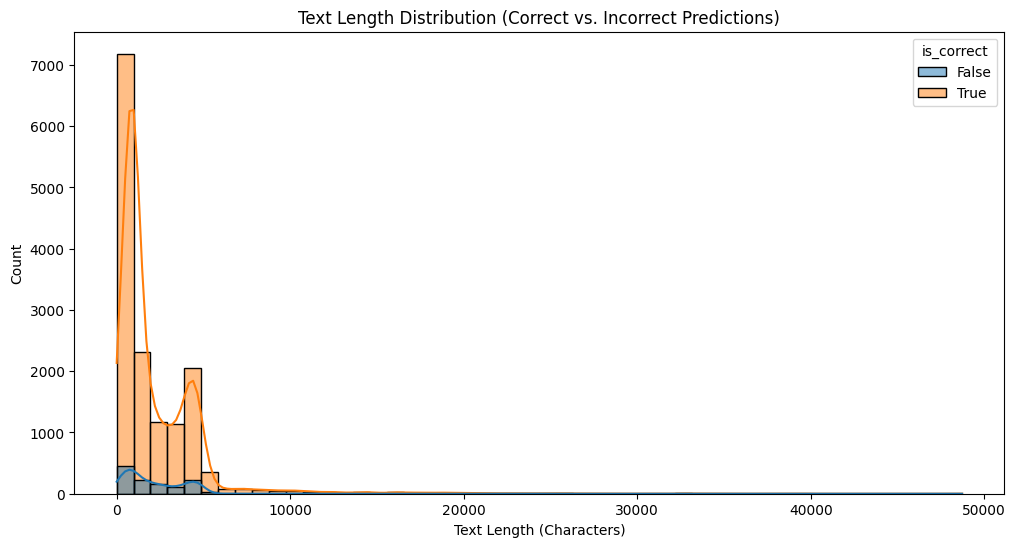

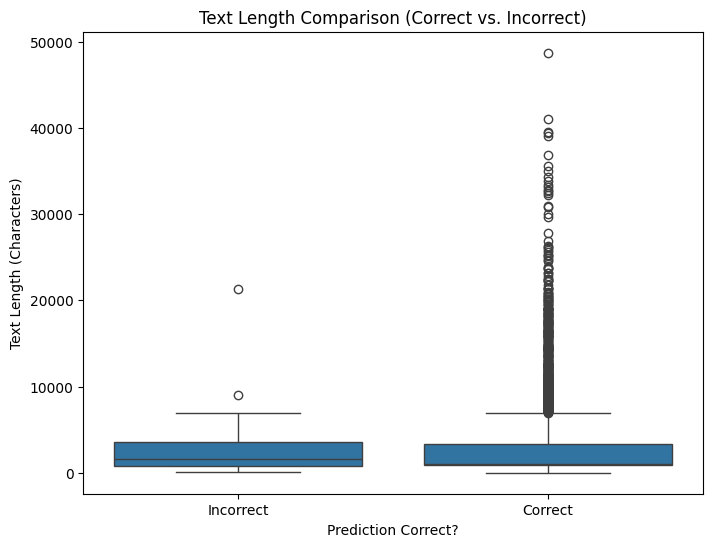

In [65]:
# --- Error Analysis ---

## 1 Text Length Analysis
print("\n--- Analyzing Text Length ---")
val_df['text_length'] = val_df['text'].apply(len)
correct_df['text_length'] = correct_df['text'].apply(len)
incorrect_df['text_length'] = incorrect_df['text'].apply(len)

print("\nDescriptive Statistics for Text Length:")
print("Correct Predictions:\n", correct_df['text_length'].describe())
print("\nIncorrect Predictions:\n", incorrect_df['text_length'].describe())

plt.figure(figsize=(12, 6))
sns.histplot(data=val_df, x='text_length', hue='is_correct', kde=True, bins=50)
plt.title('Text Length Distribution (Correct vs. Incorrect Predictions)')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Count')
#plt.savefig(os.path.join(OUTPUT_DIR, "length_histogram.png"))
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data=val_df, x='is_correct', y='text_length')
plt.title('Text Length Comparison (Correct vs. Incorrect)')
plt.xlabel('Prediction Correct?')
plt.ylabel('Text Length (Characters)')
plt.xticks([False, True], ['Incorrect', 'Correct'])
#plt.savefig(os.path.join(OUTPUT_DIR, "length_boxplot.png"))
plt.show()


--- Analyzing Text Length by Result Type (TP, TN, FP, FN) ---

--- Analyzing Text Length ---

Descriptive Statistics for Text Length:
TN Predictions:
 count     6857.000000
mean      2381.524865
std       3756.805404
min         38.000000
25%        907.000000
50%        951.000000
75%       1892.000000
max      48723.000000
Name: text_length, dtype: float64

FP Predictions:
 count     1061.000000
mean      2111.380773
std       1683.078423
min         40.000000
25%        828.000000
50%       1596.000000
75%       3490.000000
max      21296.000000
Name: text_length, dtype: float64

TP Predictions:
 count    7940.000000
mean     2116.603275
std      1624.539831
min         5.000000
25%       619.000000
50%      1647.000000
75%      3753.750000
max      5832.000000
Name: text_length, dtype: float64

FN Predictions:
 count     142.000000
mean     1957.739437
std      1664.951961
min        44.000000
25%       457.000000
50%      1425.000000
75%      3676.500000
max      5102.000000
Name

<ipython-input-66-f58efbca53ca>:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Result Type')


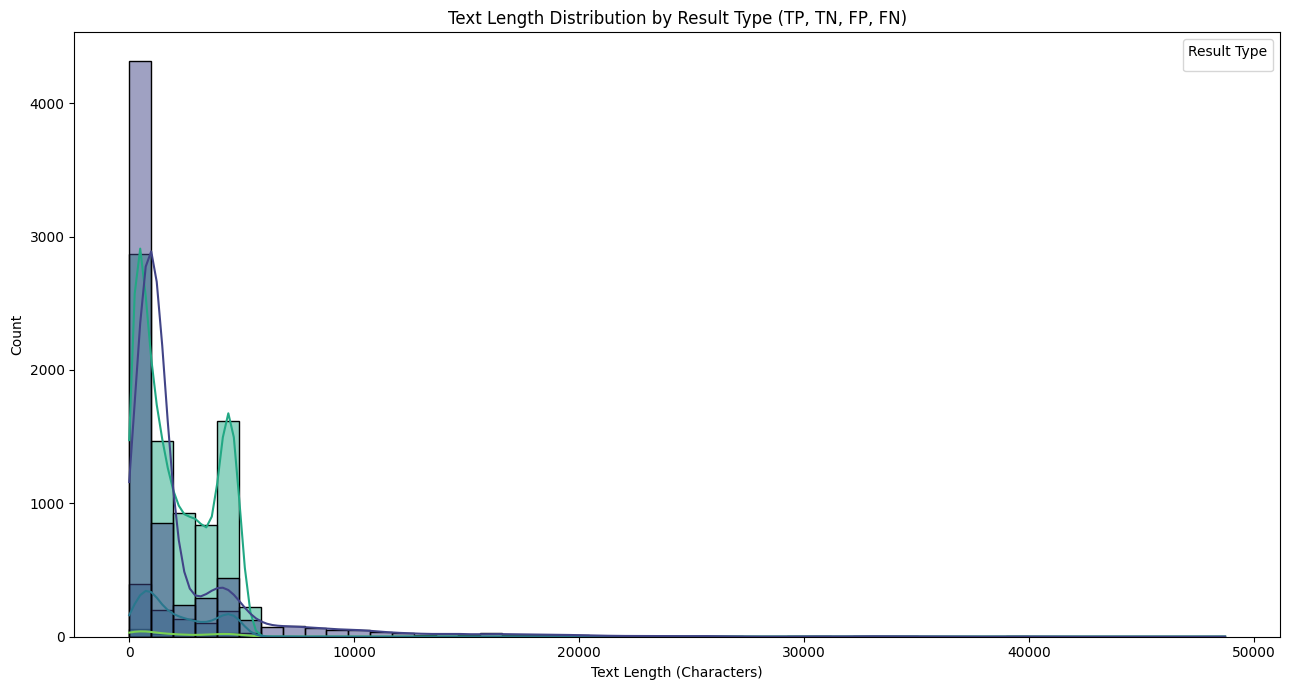

Generating boxplot by result type...


<ipython-input-66-f58efbca53ca>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='result_type', y='text_length',


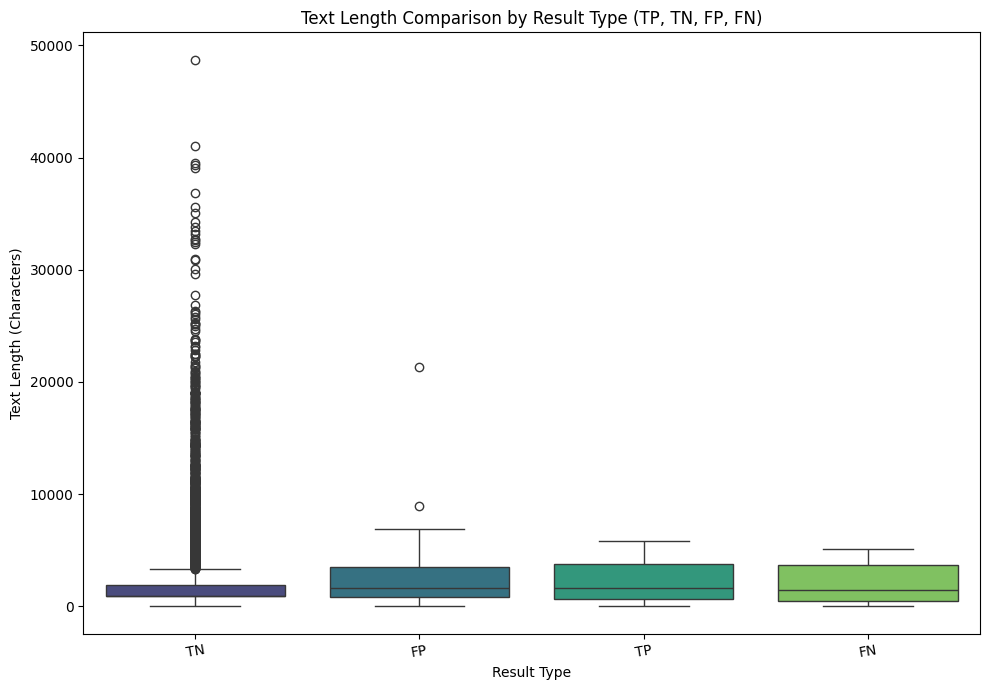

In [66]:
# --- Text Length Analysis by Result Type (TP, TN, FP, FN) ---
print("\n--- Analyzing Text Length by Result Type (TP, TN, FP, FN) ---")

## 1 Text Length Analysis
print("\n--- Analyzing Text Length ---")
tn_df['text_length'] = tn_df['text'].apply(len)
fp_df['text_length'] = fp_df['text'].apply(len)
tp_df['text_length'] = tp_df['text'].apply(len)
fn_df['text_length'] = fn_df['text'].apply(len)

print("\nDescriptive Statistics for Text Length:")
print("TN Predictions:\n", tn_df['text_length'].describe())
print("\nFP Predictions:\n", fp_df['text_length'].describe())
print("\nTP Predictions:\n", tp_df['text_length'].describe())
print("\nFN Predictions:\n", fn_df['text_length'].describe())

# Define the desired order for plot categories
type_order = ['TN', 'FP', 'TP', 'FN']

plot_data = val_df[val_df['result_type'].isin(type_order) & val_df['text_length'].notna()].copy()

if plot_data.empty:
    print("No data found for TP/TN/FP/FN categories. Skipping plots.")
else:
    # 1. Histogram by Result Type
    print("Generating histogram by result type...")
    plt.figure(figsize=(13, 7))
    sns.histplot(data=plot_data, x='text_length', hue='result_type', kde=True, bins=50,
                 hue_order=type_order, palette='viridis')
    plt.title('Text Length Distribution by Result Type (TP, TN, FP, FN)')
    plt.xlabel('Text Length (Characters)')
    plt.ylabel('Count')
    plt.legend(title='Result Type')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.tight_layout()
    #plt.savefig(os.path.join(OUTPUT_DIR, "length_histogram_by_type.png"))
    plt.show()

    # 2. Box Plot by Result Type
    print("Generating boxplot by result type...")
    plt.figure(figsize=(10, 7))
    sns.boxplot(data=plot_data, x='result_type', y='text_length',
                order=type_order, palette='viridis')
    plt.title('Text Length Comparison by Result Type (TP, TN, FP, FN)')
    plt.xlabel('Result Type')
    plt.ylabel('Text Length (Characters)')
    plt.xticks(rotation=10)
    plt.tight_layout()
    #plt.savefig(os.path.join(OUTPUT_DIR, "length_boxplot_by_type.png"))
    plt.show()

In [67]:
from tqdm.notebook import tqdm
from textstat import difficult_words
import textstat
## 2 Text Complexity Analysis
print("\n--- Analyzing Text Complexity ---")

# Function to calculate all scores
def calculate_complexity(text):
  try:
    return pd.Series({
            'difficult_words': difficult_words(text)
        })
  except Exception:
    return pd.Series({
            'difficult_words': np.nan
        })


# Apply complexity calculations
tqdm.pandas(desc="Calculating Complexity")
complexity_scores = val_df['text'].progress_apply(calculate_complexity)
val_df = pd.concat([val_df, complexity_scores], axis=1)



--- Analyzing Text Complexity ---


Calculating Complexity:   0%|          | 0/16000 [00:00<?, ?it/s]


Average Complexity Scores:
            difficult_words
is_correct                 
False             68.642560
True              65.146787


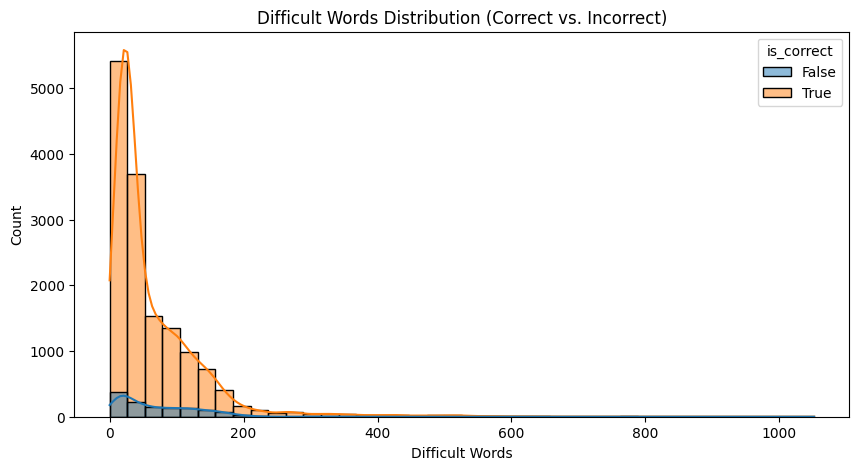

In [68]:
# Compare average scores
print("\nAverage Complexity Scores:")
print(val_df.groupby('is_correct')[['difficult_words']].mean())

# Plot distributions
complexity_metrics = ['difficult_words']
for metric in complexity_metrics:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=val_df, x=metric, hue='is_correct', kde=True, bins=40)
    plt.title(f'{metric.replace("_", " ").title()} Distribution (Correct vs. Incorrect)')
    plt.xlabel(metric.replace("_", " ").title())
    plt.ylabel('Count')
    #plt.savefig(os.path.join(OUTPUT_DIR, f"complexity_{metric}_hist.png"))
    plt.show()


--- Analyzing Text Complexity by Four Result Types (TN, FP, TP, FN) ---
Shape before duplicate removal: (16000, 8)
Shape after duplicate removal: (16000, 8)
Columns after duplicate removal: Index(['text', 'label', 'prediction', 'pred_probability', 'is_correct',
       'result_type', 'text_length', 'difficult_words'],
      dtype='object')

Descriptive Statistics for Complexity Metrics by Result Type:

--- Difficult Words ---
              count       mean         std  min    25%   50%    75%     max
result_type                                                                
TN           6857.0  71.471489  105.380530  0.0  22.00  29.0   67.0  1052.0
FP           1061.0  70.264844   56.481493  0.0  22.00  54.0  113.0   518.0
TP           7940.0  59.684761   45.943318  0.0  19.00  50.0   92.0   219.0
FN            142.0  56.521127   47.638520  0.0  15.25  43.0   91.0   203.0

Generating complexity plots by four result types (TN, FP, TP, FN)...


<ipython-input-69-52444f8c884a>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data_metric, x='result_type', y=metric, order=type_order, palette='viridis')


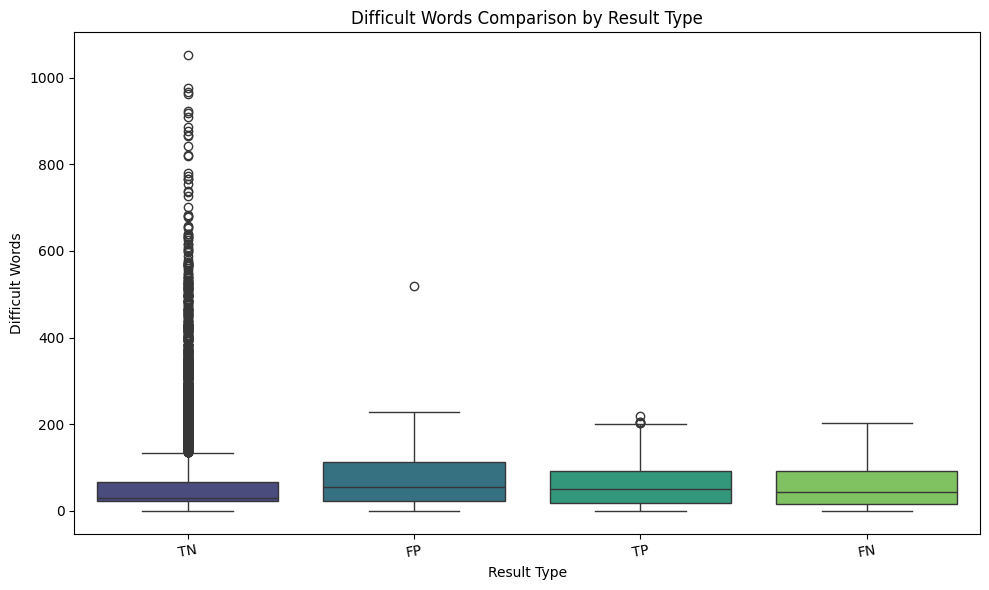

Could not generate legend for difficult_words histogram.


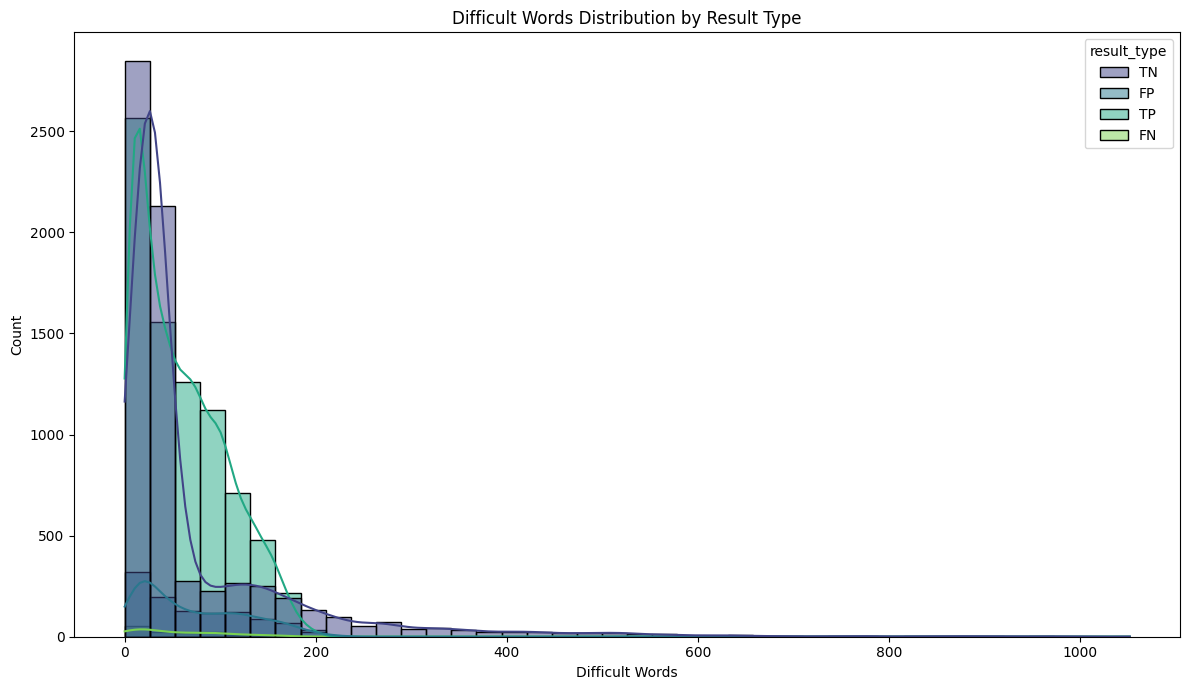

In [69]:
print("\n--- Analyzing Text Complexity by Four Result Types (TN, FP, TP, FN) ---")

type_order = ['TN', 'FP', 'TP', 'FN']
print("Shape before duplicate removal:", val_df.shape)
val_df = val_df.loc[:, ~val_df.columns.duplicated(keep='first')]
print("Shape after duplicate removal:", val_df.shape)
print("Columns after duplicate removal:", val_df.columns)

plot_data_four_types = val_df[val_df['result_type'].isin(type_order)].copy()

print("\nDescriptive Statistics for Complexity Metrics by Result Type:")
for metric in complexity_metrics:
    if metric in plot_data_four_types.columns:
        print(f"\n--- {metric.replace('_', ' ').title()} ---")
        stats = plot_data_four_types.groupby('result_type')[metric].describe()
        try:
            print(stats.reindex(type_order))
        except KeyError:
            print("Warning: Not all result types found in data for stats ordering.")
            print(stats)
    else:
        print(f"Metric '{metric}' not found for descriptive stats.")


print("\nGenerating complexity plots by four result types (TN, FP, TP, FN)...")
for metric in complexity_metrics:
    if metric in plot_data_four_types and pd.api.types.is_numeric_dtype(plot_data_four_types[metric]):

        plot_data_metric = plot_data_four_types.dropna(subset=[metric, 'result_type'])

        if not plot_data_metric.empty:
            # 1. Box Plot
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=plot_data_metric, x='result_type', y=metric, order=type_order, palette='viridis')
            plt.title(f'{metric.replace("_", " ").title()} Comparison by Result Type')
            plt.xlabel('Result Type')
            plt.ylabel(metric.replace("_", " ").title())
            plt.xticks(rotation=10)
            plt.tight_layout()
            #plt.savefig(os.path.join(OUTPUT_DIR, f"complexity_{metric}_boxplot_four_types.png"))
            plt.show()

            # 2. Histogram
            plt.figure(figsize=(12, 7))
            # Use histplot with hue
            ax = sns.histplot(data=plot_data_metric, x=metric, hue='result_type',
                              hue_order=type_order, kde=True, bins=40, palette='viridis',
                              common_norm=False)
            plt.title(f'{metric.replace("_", " ").title()} Distribution by Result Type')
            plt.xlabel(metric.replace("_", " ").title())
            plt.ylabel('Count')

            handles, labels = ax.get_legend_handles_labels()
            if handles and labels:
                 ax.legend(handles=handles, labels=labels, title='Result Type', bbox_to_anchor=(1.02, 1), loc='upper left')
                 plt.subplots_adjust(right=0.85)
            else:
                 print(f"Could not generate legend for {metric} histogram.")
                 plt.tight_layout()

            #plt.savefig(os.path.join(OUTPUT_DIR, f"complexity_{metric}_hist_four_types.png"))
            plt.show()
        else:
            print(f"No valid data to plot for {metric} across four types after dropping NaNs.")
    else:
        print(f"Skipping plots for {metric} as column is missing or not numeric in filtered data.")


--- Analyzing Top Keywords ---

Top 20 Keywords for Correct Predictions:
   Keyword  Frequency
0     said      14053
1   people      13481
2      new      12350
3     time      10523
4     like       9892
5     just       9628
6     make       7654
7      way       6478
8      use       6407
9     know       5849
10   world       5834
11   years       5599
12    good       5178
13    work       5147
14    dont       5090
15    want       4992
16   going       4926
17    need       4890
18    used       4752
19   think       4697


<ipython-input-70-1d73878d057e>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


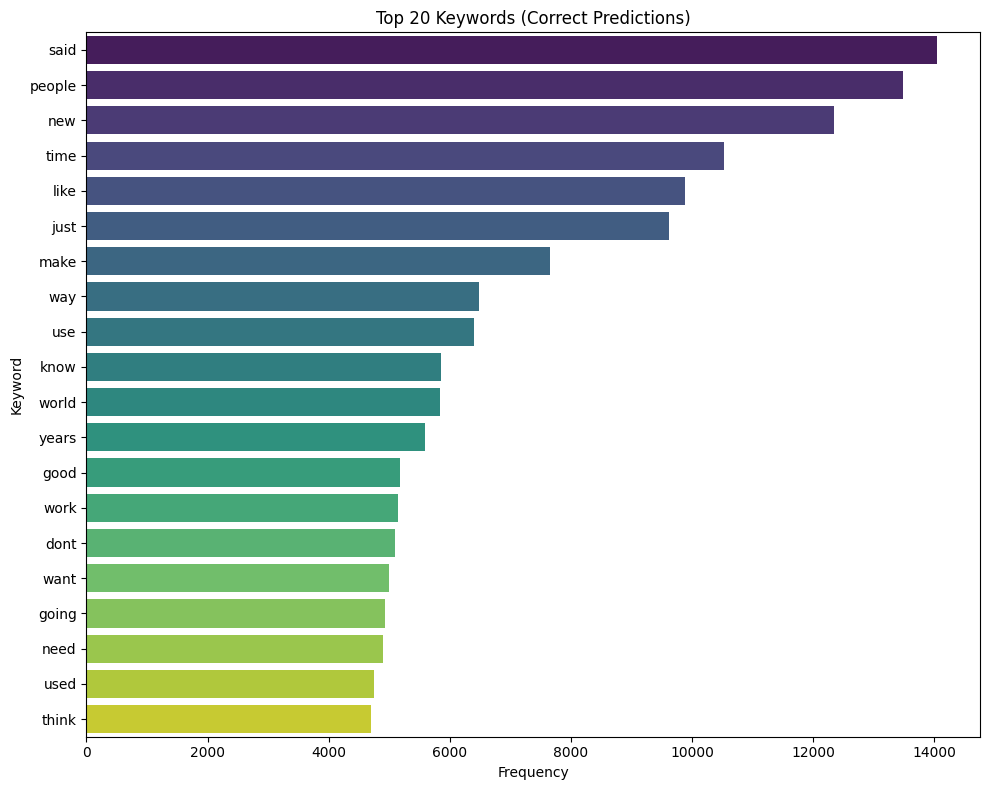


Top 20 Keywords for Incorrect Predictions:
       Keyword  Frequency
0         said       1404
1          new        853
2       people        788
3         just        708
4         time        699
5         like        688
6          use        470
7         year        468
8         make        462
9        years        458
10        dont        399
11         way        393
12       state        375
13        know        368
14        game        362
15       think        349
16       world        336
17  government        333
18        good        328
19      police        322


<ipython-input-70-1d73878d057e>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


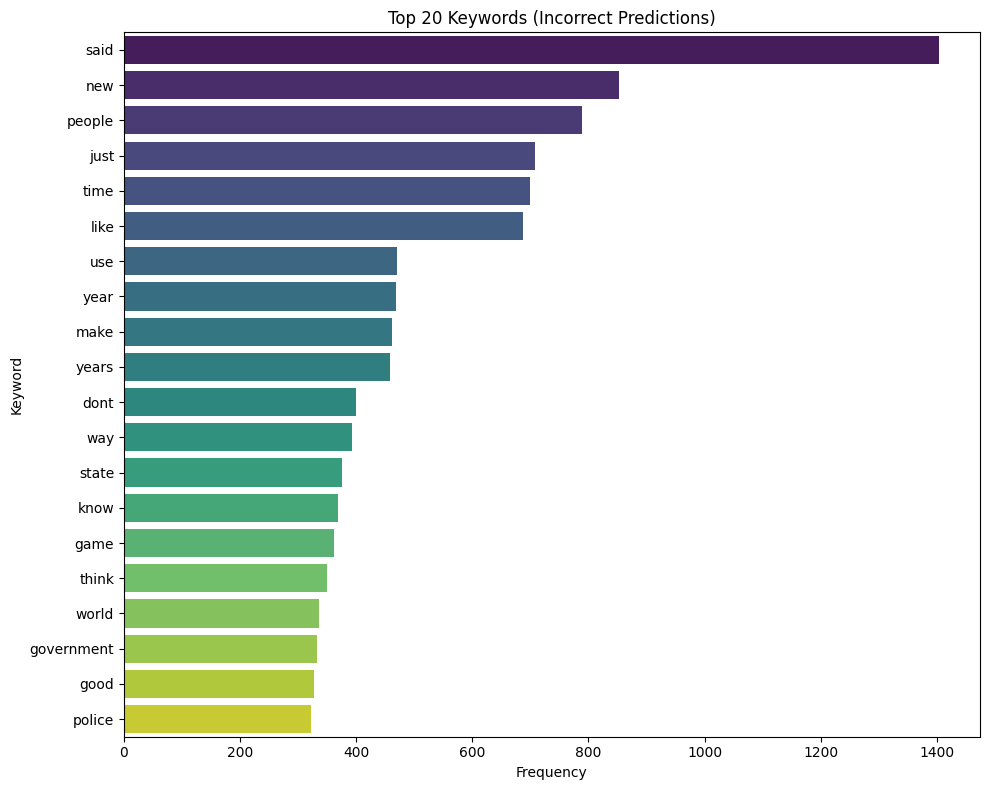

In [70]:
## 3 Keyword Analysis
print("\n--- Analyzing Top Keywords ---")

def plot_top_keywords(df, text_column, title_suffix, num_keywords=20, filename_suffix=""):
    if len(df) == 0:
        print(f"Skipping keyword analysis for '{title_suffix}': No samples.")
        return

    print(f"\nTop {num_keywords} Keywords for {title_suffix}:")
    try:
        vec = CountVectorizer(stop_words='english', max_features=num_keywords).fit(df[text_column])
        bag_of_words = vec.transform(df[text_column])
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

        top_df = pd.DataFrame(words_freq[:num_keywords], columns=['Keyword', 'Frequency'])
        print(top_df)

        plt.figure(figsize=(10, 8))
        sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')
        plt.title(f'Top {num_keywords} Keywords ({title_suffix})')
        plt.tight_layout()
        #plt.savefig(os.path.join(OUTPUT_DIR, f"keywords_{filename_suffix}.png"))
        plt.show()

    except ValueError as e:
        print(f"Could not generate keywords for {title_suffix}: {e}")

# Compare Correct vs Incorrect
plot_top_keywords(correct_df, 'text', 'Correct Predictions', filename_suffix="correct")
plot_top_keywords(incorrect_df, 'text', 'Incorrect Predictions', filename_suffix="incorrect")

# analyze FP and FN separately
# plot_top_keywords(fp_df, 'text', 'False Positives (Human -> AI)', filename_suffix="fp")
# plot_top_keywords(fn_df, 'text', 'False Negatives (AI -> Human)', filename_suffix="fn")


Top 20 Keywords for True Negatives (Human):
      Keyword  Frequency
0      people       5557
1        time       4937
2        like       4524
3        just       4139
4         new       3936
5        said       3261
6       world       2968
7     company       2932
8         way       2826
9         use       2689
10       life       2674
11       work       2496
12       make       2460
13       know       2455
14       used       2371
15  different       2368
16      years       2337
17        man       2127
18   business       2125
19        did       2103


<ipython-input-70-1d73878d057e>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


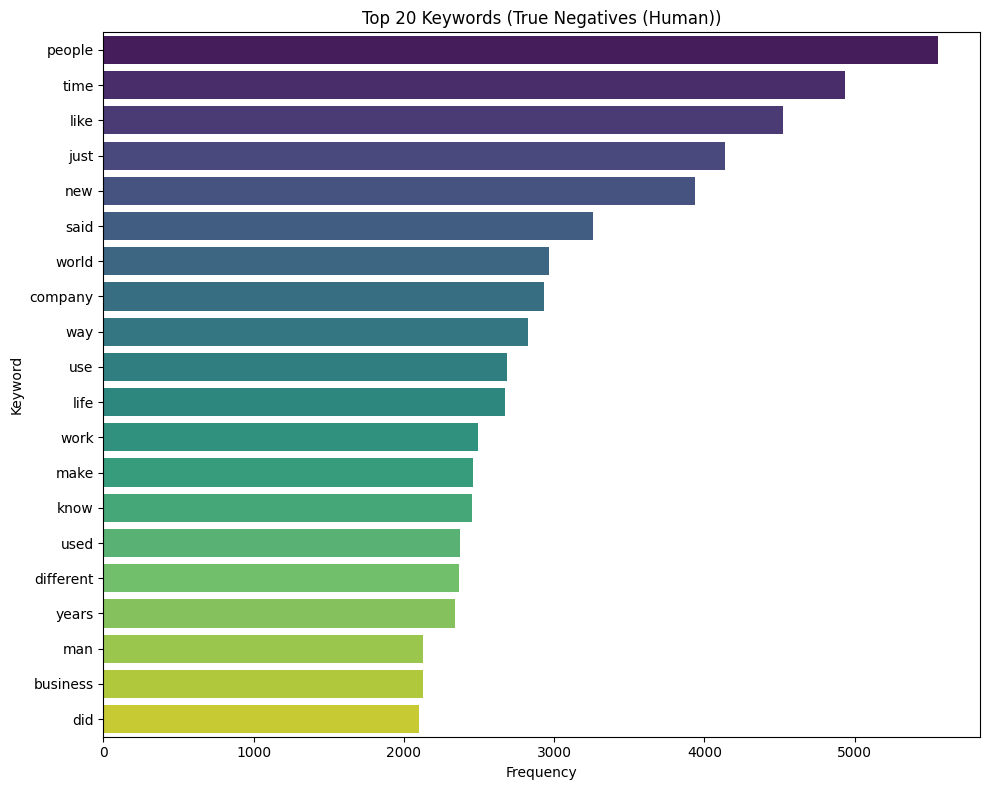


Top 20 Keywords for False Positives (Human -> AI):
       Keyword  Frequency
0         said       1319
1          new        736
2       people        732
3         just        637
4         time        624
5         like        614
6         year        421
7         make        411
8          use        408
9        years        405
10        dont        355
11         way        342
12        know        321
13       state        320
14        game        309
15       world        306
16       think        302
17  government        294
18      police        291
19        want        290


<ipython-input-70-1d73878d057e>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


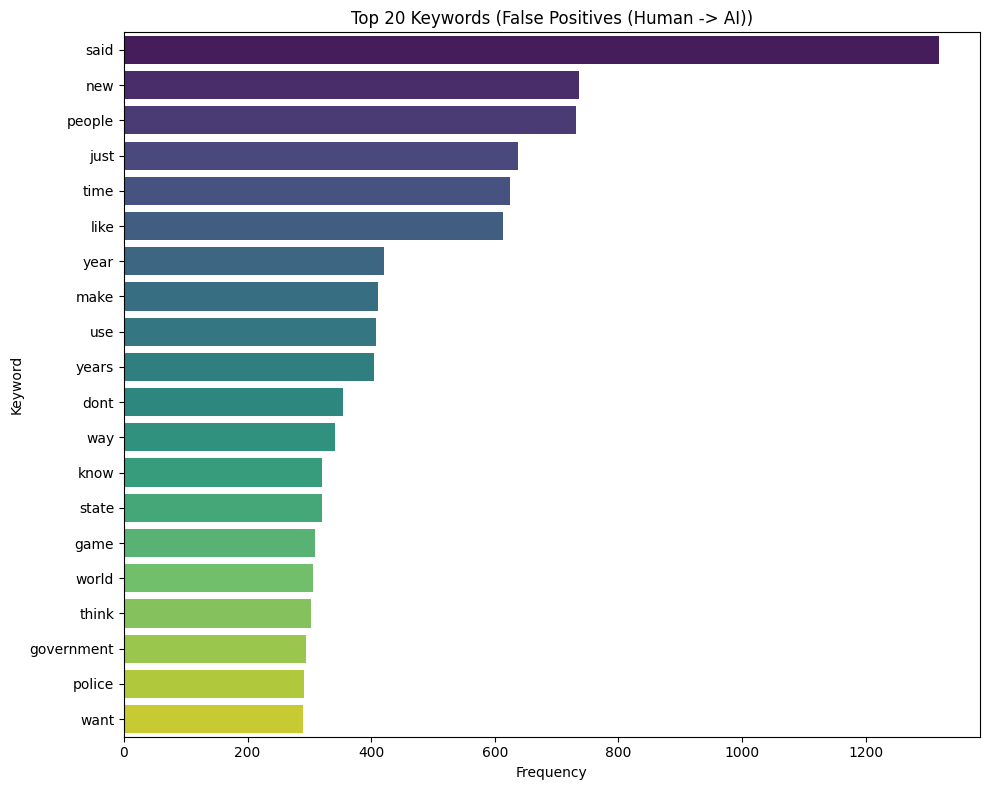


Top 20 Keywords for False Negatives (AI -> Human):
    Keyword  Frequency
0       new        117
1      said         85
2      time         75
3      like         74
4      just         71
5       use         62
6      days         61
7    people         56
8     state         55
9      game         53
10    years         53
11     team         53
12  exports         53
13     make         51
14      way         51
15    party         50
16     view         50
17      men         49
18     used         48
19     good         47


<ipython-input-70-1d73878d057e>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


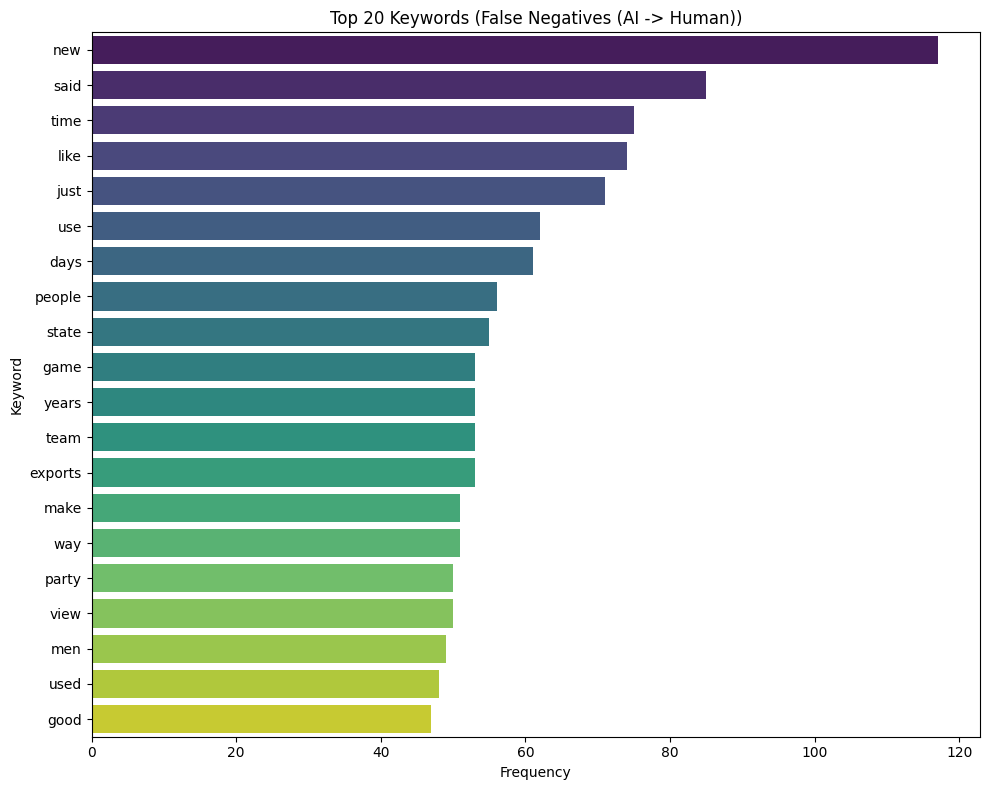


Top 20 Keywords for True Positives (AI):
       Keyword  Frequency
0         said      10792
1          new       8414
2       people       7924
3         time       5586
4         just       5489
5         like       5368
6         make       5194
7         want       3749
8          use       3718
9          way       3652
10        dont       3483
11       going       3473
12        know       3394
13       years       3262
14       think       3237
15        good       3220
16        year       3090
17        game       3037
18        need       2997
19  government       2949


<ipython-input-70-1d73878d057e>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')


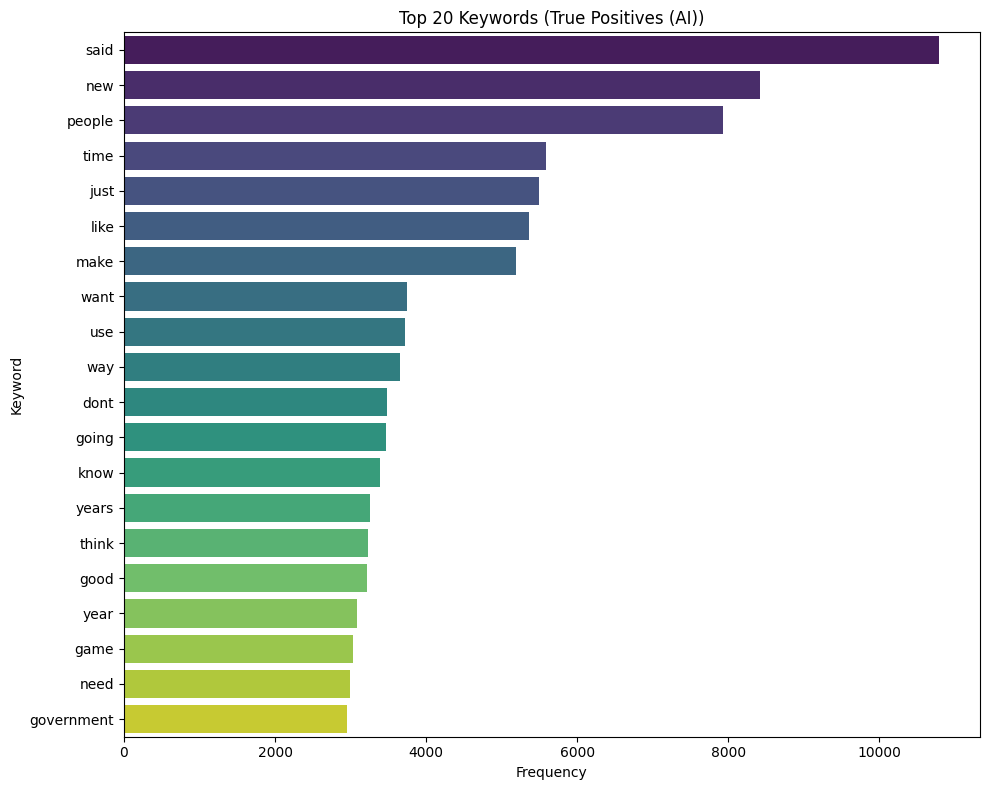

In [71]:
plot_top_keywords(tn_df, 'text', 'True Negatives (Human)', filename_suffix="tn")
plot_top_keywords(fp_df, 'text', 'False Positives (Human -> AI)', filename_suffix="fp")
plot_top_keywords(fn_df, 'text', 'False Negatives (AI -> Human)', filename_suffix="fn")
plot_top_keywords(tp_df, 'text', 'True Positives (AI)', filename_suffix="tp")


--- Analyzing N-grams ---

-- Top 2-grams --

Top 2-grams for Correct Predictions:
      2-gram  Frequency
0     of the      40738
1     in the      33586
2     to the      17325
3     on the      13540
4    and the      11073
5      to be      10624
6    for the      10103
7   that the       9609
8      it is       8435
9       in a       8293
10  with the       8083
11    at the       7699
12      is a       7530
13  from the       7099
14      of a       6742
15      as a       6228
16    by the       6082
17    it was       5968
18    is the       5124
19   will be       4963


<ipython-input-72-3e187495d2c7>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


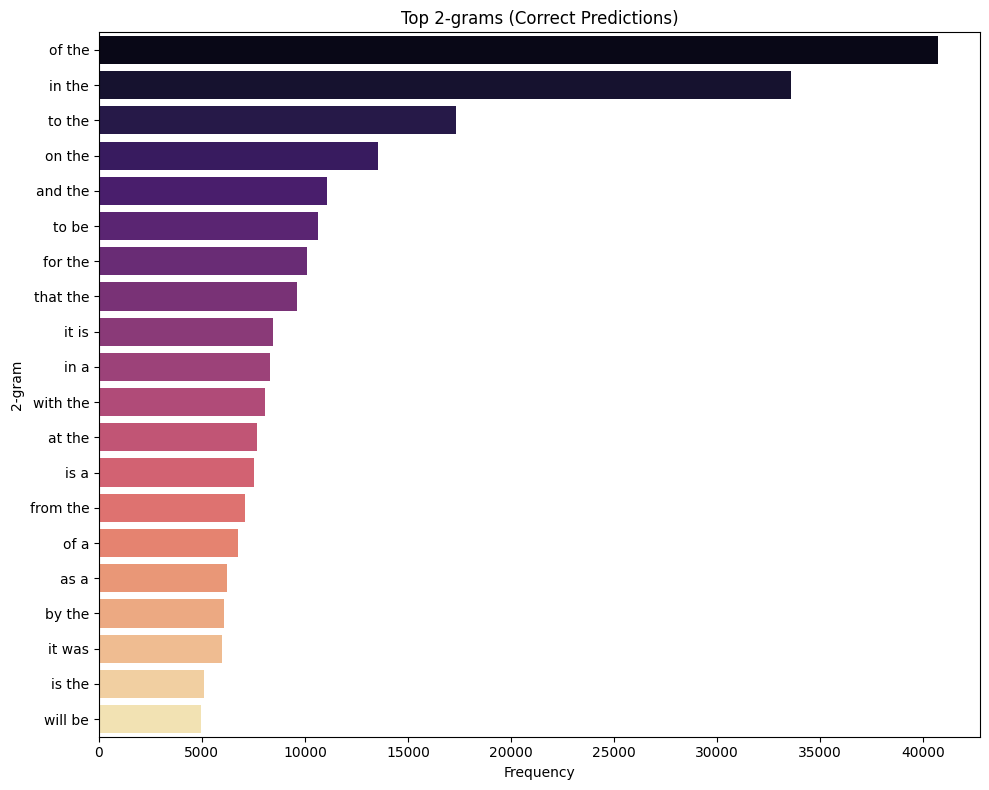


Top 2-grams for Incorrect Predictions:
       2-gram  Frequency
0      of the       2711
1      in the       2465
2      to the       1171
3      on the        927
4     for the        796
5       to be        656
6     and the        625
7        in a        610
8      at the        596
9    with the        593
10   that the        584
11       is a        555
12   from the        538
13       of a        481
14      it is        470
15     by the        465
16       as a        415
17  the first        383
18     with a        364
19     is the        357


<ipython-input-72-3e187495d2c7>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


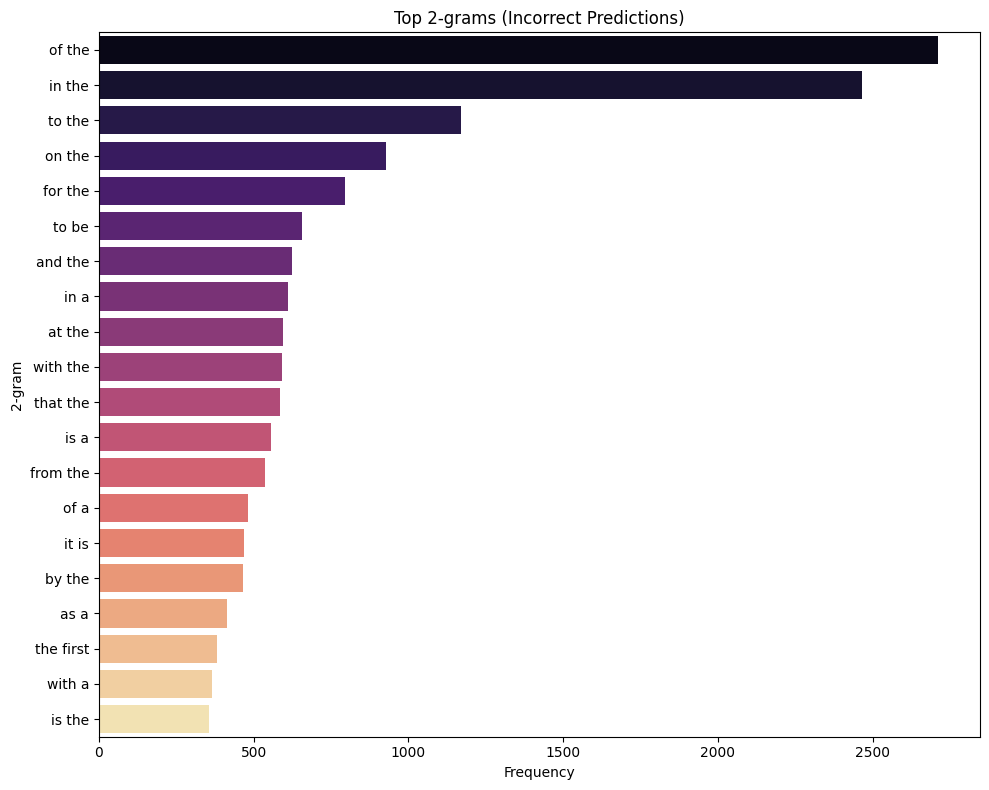


-- Top 3-grams --

Top 3-grams for Correct Predictions:
               3-gram  Frequency
0          one of the       3011
1            a lot of       2392
2   the united states       2278
3          as well as       1964
4         in order to       1530
5          be able to       1528
6       the fact that       1384
7         some of the       1263
8    according to the       1224
9             to be a       1080
10        a number of       1072
11      the number of        987
12        part of the        976
13         there is a        932
14         the use of        877
15         the end of        873
16          this is a        862
17       in the world        852
18        as a result        851
19         out of the        844


<ipython-input-72-3e187495d2c7>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


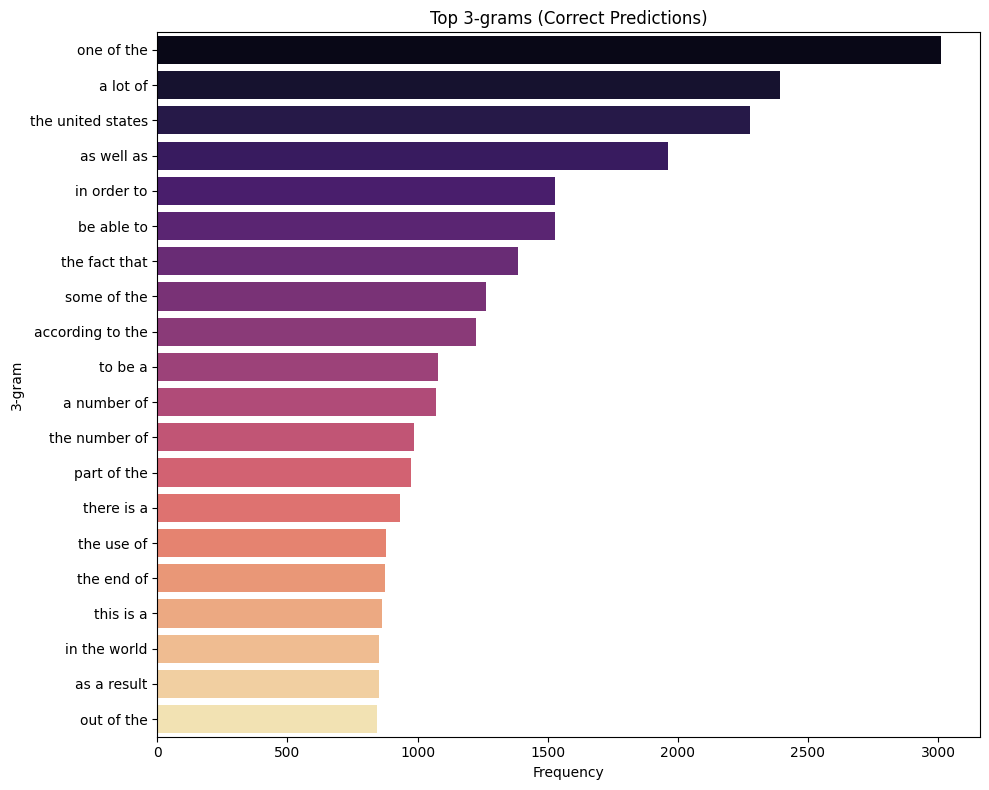


Top 3-grams for Incorrect Predictions:
               3-gram  Frequency
0          one of the        177
1            a lot of        125
2   the united states        122
3          as well as        117
4    according to the        103
5         some of the         85
6          be able to         81
7         part of the         78
8          the end of         73
9           this is a         67
10         there is a         63
11        in order to         63
12     the first time         63
13            to be a         63
14         out of the         59
15          in the us         58
16        a number of         55
17      the number of         54
18        this is the         54
19         the use of         53


<ipython-input-72-3e187495d2c7>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


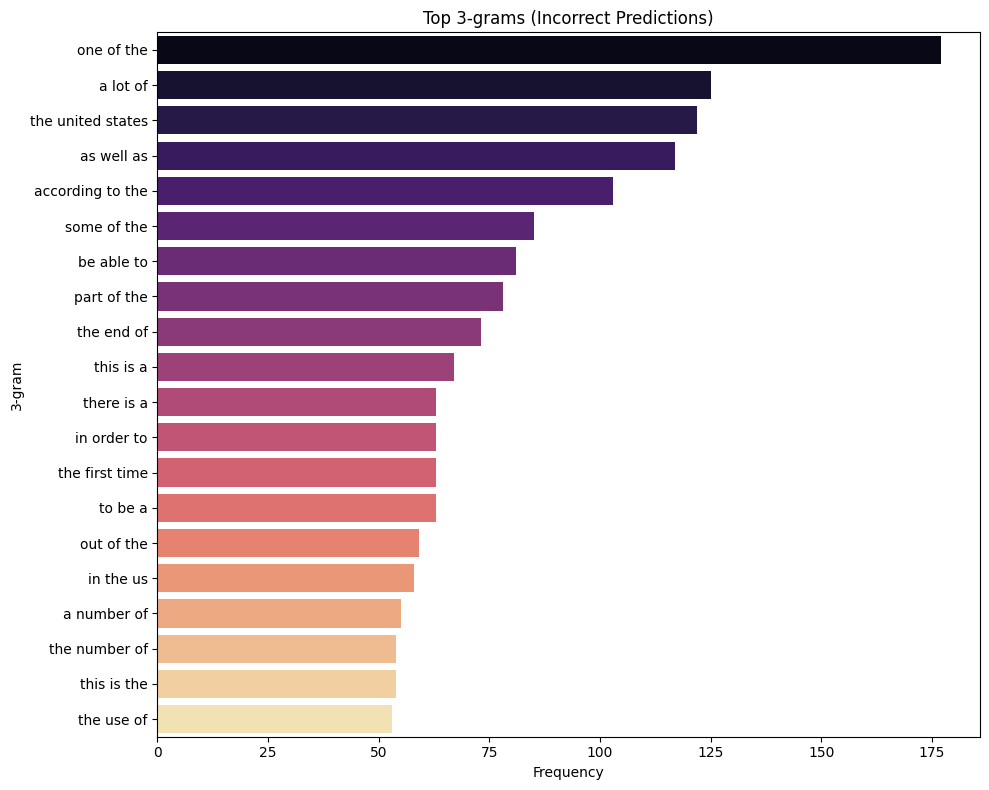

In [72]:
## 4 N-gram Analysis
print("\n--- Analyzing N-grams ---")

def get_top_ngrams(text_series, n=2, num_ngrams=20):
    if len(text_series) == 0:
        return pd.DataFrame(columns=[f'{n}-gram', 'Frequency'])

    # Simple whitespace and punctuation cleaning for n-grams
    def clean_for_ngrams(text):
        text = text.lower()
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text) # Remove punctuation
        text = re.sub(r'\s+', ' ', text).strip() # Normalize whitespace
        return text

    all_ngrams = []
    cleaned_texts = text_series.apply(clean_for_ngrams)
    for text in cleaned_texts:
        words = text.split()
        if len(words) >= n:
            grams = [" ".join(words[i:i+n]) for i in range(len(words) - n + 1)]
            all_ngrams.extend(grams)

    if not all_ngrams:
        return pd.DataFrame(columns=[f'{n}-gram', 'Frequency'])

    ngram_freq = Counter(all_ngrams)
    common_ngrams = ngram_freq.most_common(num_ngrams)
    return pd.DataFrame(common_ngrams, columns=[f'{n}-gram', 'Frequency'])

def plot_ngrams(df, title, filename):
    if df.empty:
        print(f"Skipping plot for '{title}': No n-grams found.")
        return
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')
    plt.title(title)
    plt.tight_layout()
    #plt.savefig(os.path.join(OUTPUT_DIR, filename))
    plt.show()


# Analyze Bigrams (n=2) and Trigrams (n=3)
for n_gram_size in [2, 3]:
    print(f"\n-- Top {n_gram_size}-grams --")

    # Correct
    top_ngrams_correct = get_top_ngrams(correct_df['text'], n=n_gram_size, num_ngrams=20)
    print(f"\nTop {n_gram_size}-grams for Correct Predictions:")
    print(top_ngrams_correct)
    plot_ngrams(top_ngrams_correct, f'Top {n_gram_size}-grams (Correct Predictions)', f"ngram{n_gram_size}_correct.png")

    # Incorrect
    top_ngrams_incorrect = get_top_ngrams(incorrect_df['text'], n=n_gram_size, num_ngrams=20)
    print(f"\nTop {n_gram_size}-grams for Incorrect Predictions:")
    print(top_ngrams_incorrect)
    plot_ngrams(top_ngrams_incorrect, f'Top {n_gram_size}-grams (Incorrect Predictions)', f"ngram{n_gram_size}_incorrect.png")

    # FP / FN
    # top_ngrams_fp = get_top_ngrams(fp_df['text'], n=n_gram_size, num_ngrams=15)
    # plot_ngrams(top_ngrams_fp, f'Top {n_gram_size}-grams (False Positives)', f"ngram{n_gram_size}_fp.png")
    # top_ngrams_fn = get_top_ngrams(fn_df['text'], n=n_gram_size, num_ngrams=15)
    # plot_ngrams(top_ngrams_fn, f'Top {n_gram_size}-grams (False Negatives)', f"ngram{n_gram_size}_fn.png")

<ipython-input-72-3e187495d2c7>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


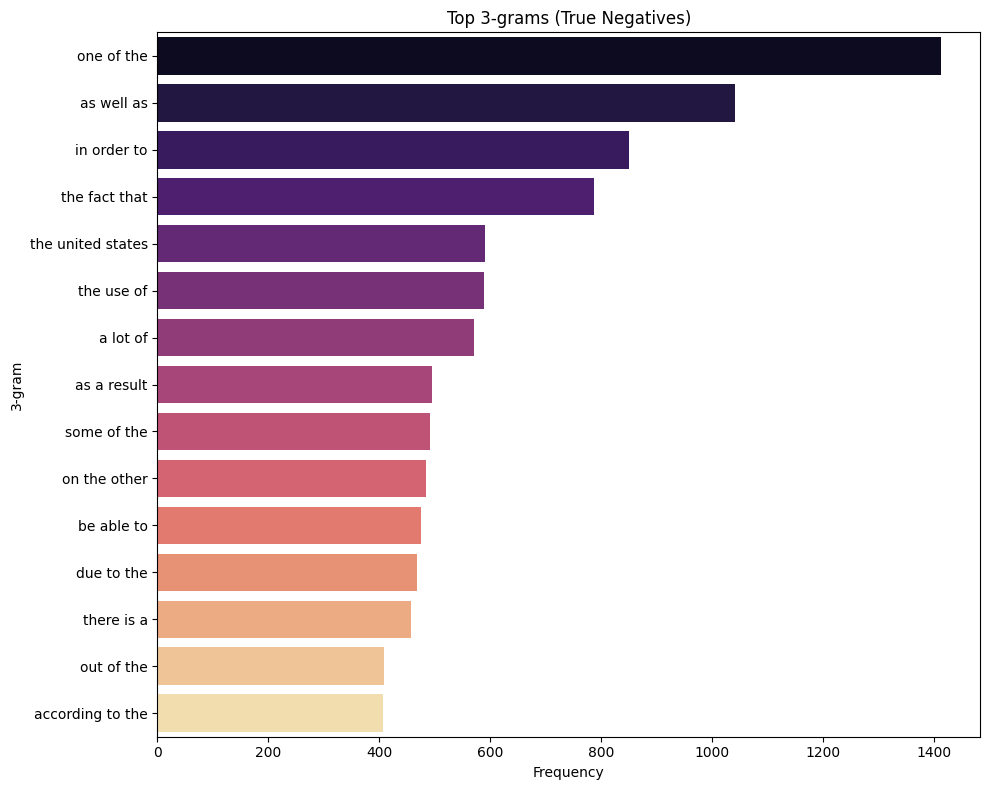

<ipython-input-72-3e187495d2c7>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


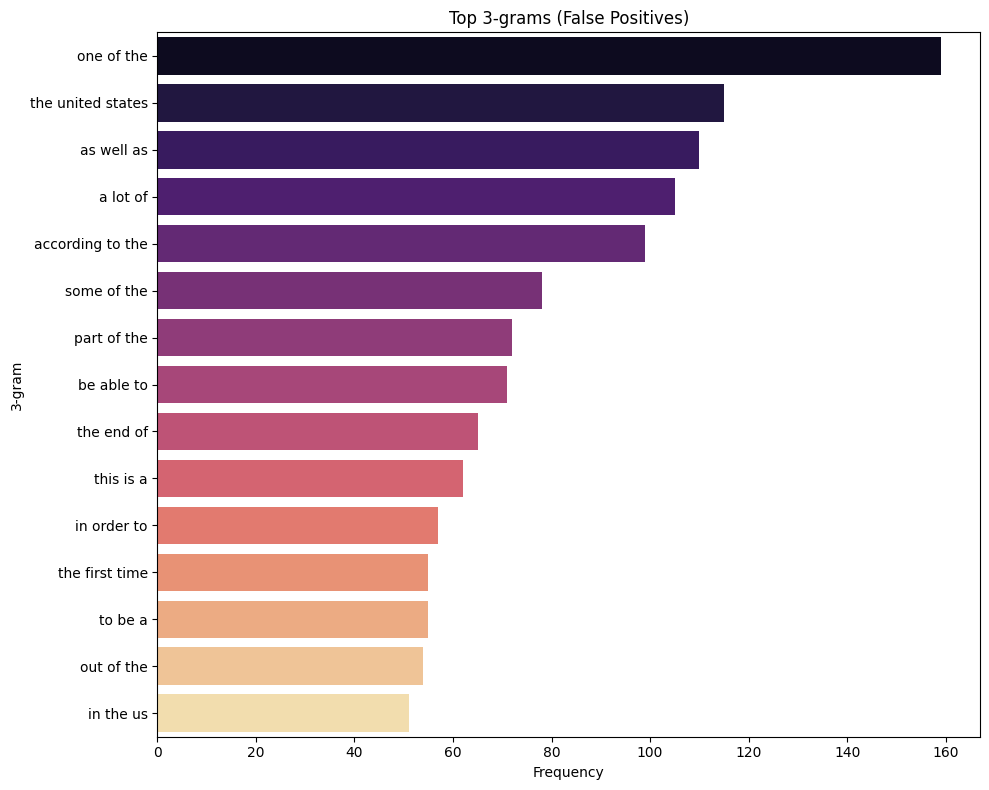

<ipython-input-72-3e187495d2c7>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


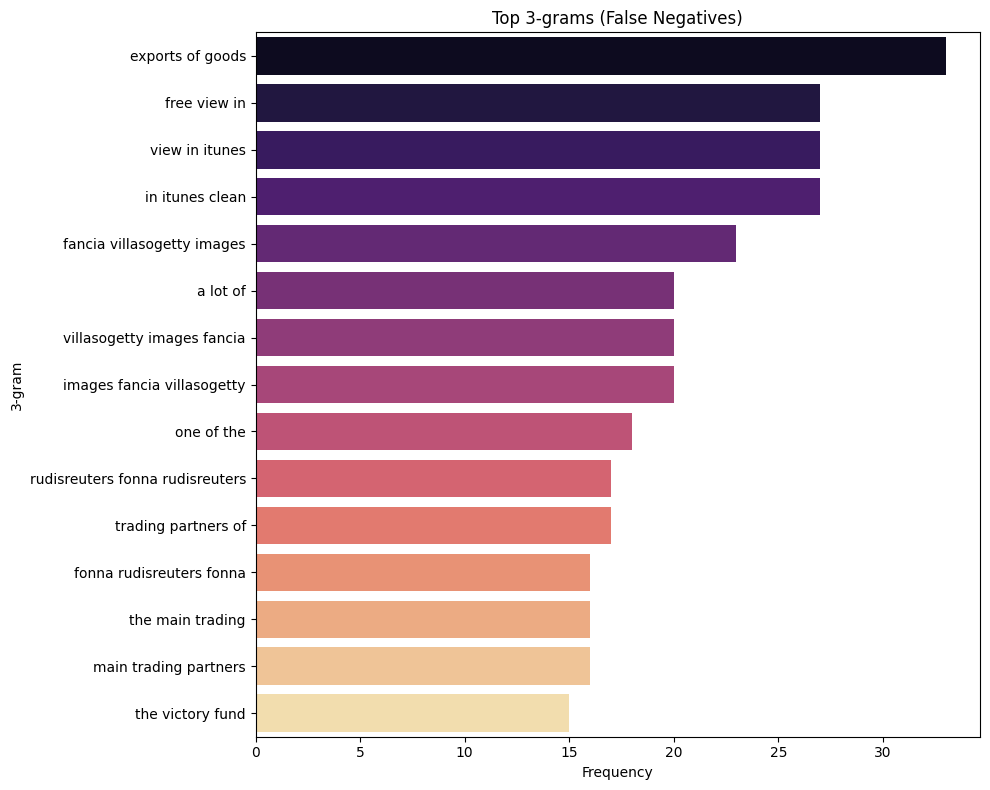

<ipython-input-72-3e187495d2c7>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')


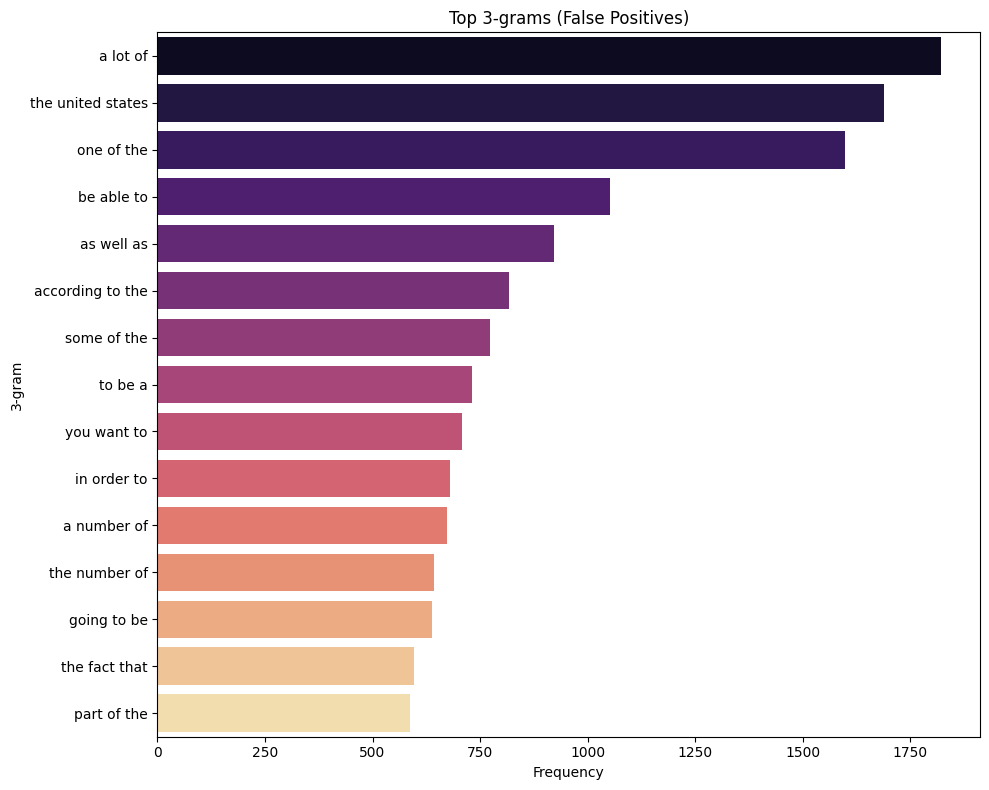

In [73]:
top_ngrams_tn = get_top_ngrams(tn_df['text'], n=n_gram_size, num_ngrams=15)
plot_ngrams(top_ngrams_tn, f'Top {n_gram_size}-grams (True Negatives)', f"ngram{n_gram_size}_tn.png")
top_ngrams_fp = get_top_ngrams(fp_df['text'], n=n_gram_size, num_ngrams=15)
plot_ngrams(top_ngrams_fp, f'Top {n_gram_size}-grams (False Positives)', f"ngram{n_gram_size}_fp.png")
top_ngrams_fn = get_top_ngrams(fn_df['text'], n=n_gram_size, num_ngrams=15)
plot_ngrams(top_ngrams_fn, f'Top {n_gram_size}-grams (False Negatives)', f"ngram{n_gram_size}_fn.png")
top_ngrams_tp = get_top_ngrams(tp_df['text'], n=n_gram_size, num_ngrams=15)
plot_ngrams(top_ngrams_tp, f'Top {n_gram_size}-grams (False Positives)', f"ngram{n_gram_size}_tp.png")


--- Analyzing Prediction Confidence ---


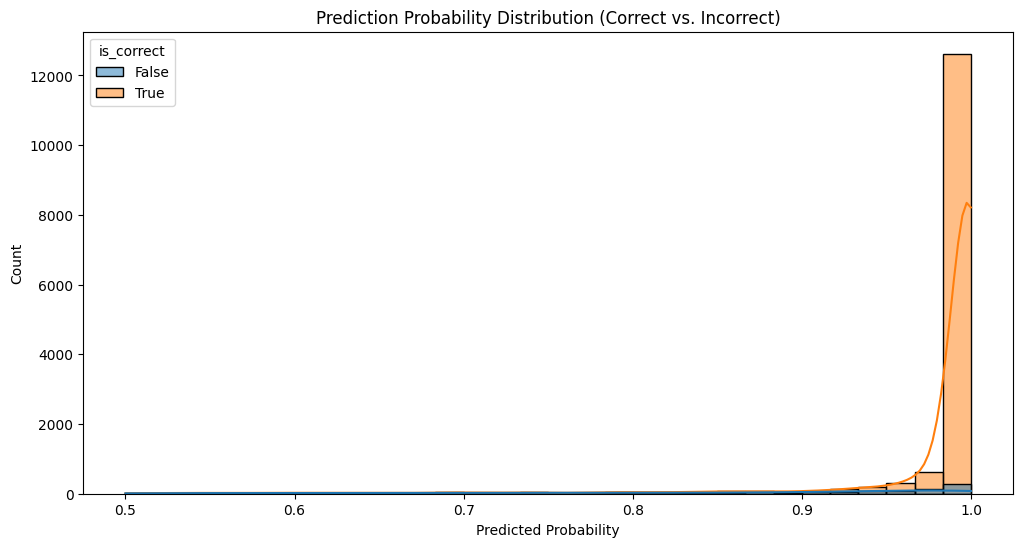


Average Prediction Probability:
is_correct
False    0.850496
True     0.979748
Name: pred_probability, dtype: float32


In [74]:
## 5 Confidence Analysis
print("\n--- Analyzing Prediction Confidence ---")
plt.figure(figsize=(12, 6))
sns.histplot(data=val_df, x='pred_probability', hue='is_correct', kde=True, bins=30)
plt.title('Prediction Probability Distribution (Correct vs. Incorrect)')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
#plt.savefig(os.path.join(OUTPUT_DIR, "confidence_histogram.png"))
plt.show()

print("\nAverage Prediction Probability:")
print(val_df.groupby('is_correct')['pred_probability'].mean())


--- Analyzing Prediction Confidence by result type ---


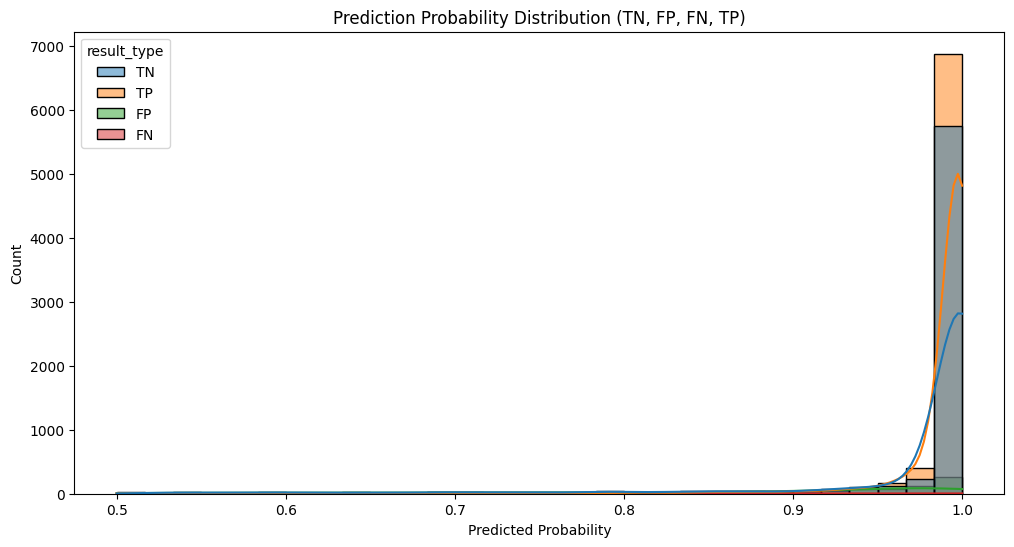


Average Prediction Probability:
result_type
FN    0.786964
FP    0.858999
TN    0.974231
TP    0.984512
Name: pred_probability, dtype: float32


In [75]:
print("\n--- Analyzing Prediction Confidence by result type ---")
plt.figure(figsize=(12, 6))
sns.histplot(data=val_df, x='pred_probability', hue='result_type', kde=True, bins=30)
plt.title('Prediction Probability Distribution (TN, FP, FN, TP)')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
#plt.savefig(os.path.join(OUTPUT_DIR, "confidence_histogram_by_type.png"))
plt.show()

print("\nAverage Prediction Probability:")
print(val_df.groupby('result_type')['pred_probability'].mean())

In [76]:
# --- 5.1 Analysis of High-Confidence Errors ---
print("\n--- Analyzing High-Confidence Errors ---")

# Define the confidence threshold
confidence_threshold = 0.90

text_col = 'text'
true_label_col = 'label'
pred_label_col = 'prediction'
prob_col = 'pred_probability'
correct_col = 'is_correct'

# Filter for incorrect predictions with high confidence
high_confidence_errors_df = val_df[
    (val_df[correct_col] == False) &
    (val_df[prob_col] > confidence_threshold)
].copy()

# Sort by probability to see the most confident errors first
high_confidence_errors_df = high_confidence_errors_df.sort_values(by=prob_col, ascending=False)

print(f"Found {len(high_confidence_errors_df)} examples where the prediction was incorrect")
print(f"but the model's confidence in the wrong prediction was > {confidence_threshold:.2f}")

# --- Displaying Examples ---

# Display the top N most confident errors
num_examples_to_show = 10

print(f"\n--- Top {num_examples_to_show} Most Confident Errors ---")

if len(high_confidence_errors_df) > 0:
    display_cols = [text_col, true_label_col, pred_label_col, prob_col]

    display_cols = [col for col in display_cols if col in high_confidence_errors_df.columns]

    for index, row in high_confidence_errors_df.head(num_examples_to_show).iterrows():
        print(f"\n--- Example Index: {index} ---")
        print(f"  True Label:       {row[true_label_col]}")
        print(f"  Predicted Label:  {row[pred_label_col]}")
        print(f"  Confidence (Wrong): {row[prob_col]:.4f}")
        # Print the first 500 characters of the text for brevity
        print(f"  Text Snippet:     {row[text_col][:500]}...")
        print("-" * 30)
else:
    print("No high-confidence errors found matching the criteria.")

# --- Saving Examples ---

if len(high_confidence_errors_df) > 0 and 'OUTPUT_DIR' in locals():
    try:
        output_filename = os.path.join(OUTPUT_DIR, f"high_confidence_errors_gt_{confidence_threshold:.2f}.csv")
        # Save to a CSV
        high_confidence_errors_df.to_csv(output_filename, index=False)
        print(f"\nSaved all {len(high_confidence_errors_df)} high-confidence error examples to: {output_filename}")
    except Exception as e:
        print(f"\nCould not save high-confidence errors to CSV: {e}")


--- Analyzing High-Confidence Errors ---
Found 635 examples where the prediction was incorrect
but the model's confidence in the wrong prediction was > 0.90

--- Top 10 Most Confident Errors ---

--- Example Index: 5828 ---
  True Label:       0
  Predicted Label:  1
  Confidence (Wrong): 0.9996
  Text Snippet:     try putting a potato chip bag in the microwave it makes a mini potato chip bag...
------------------------------

--- Example Index: 2391 ---
  True Label:       0
  Predicted Label:  1
  Confidence (Wrong): 0.9995
  Text Snippet:     what youll need ounces semisweet or bittersweet chocolate finely chopped cup heavy cream the chocolate must first be chopped into small pieces so that it will melt evenly if you leave it in large chunks the outside surface will melt long before the center begins to soften and the melted portion will stay hot too long which can ruin the ganache use a heavy serrated knife or a chocolate chopper to shave off shards of chocolate these can then be 